# Customer Segmentation Using Cohort, RFM and Clustering Analyses

## Importing Libraries and Data

In [816]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#import missingno as msno
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
import warnings
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [817]:
# set plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # improves resolutions of inline plots
sns.set_theme(style='white')
sns.set_style("ticks")
sns.set_context("paper")
rcParams['axes.titlepad'] = 12    # set a distance between title and plot

In [818]:
# loading the csv data file as dataframe
df = pd.read_csv("C:/Users/tomna/Desktop/Desktop/Notebooks/E-commerce/data.csv", encoding='unicode_escape')

## Data Profiling & Cleaning

In [819]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [820]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [821]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [822]:
df.shape

(541909, 8)

In [823]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


There are some negative values in the Quantity and UnitPrice columns, lets confirm how many are there

In [824]:
(df[['Quantity', 'UnitPrice']] < 0).any()

Quantity     True
UnitPrice    True
dtype: bool

In [825]:
# determing total number of negatives values in Quantity column
np.sum(df.Quantity < 0)

10624

There are around 10k purchases with negative quantity, most likely returns. We will remove them later.

In [826]:
# determing total number of negatives values in Quantity column
np.sum(df.UnitPrice < 0)

2

In [827]:
# converting InvoiceDate to datetime format
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [828]:
# analysing missing values in each column
null_cols = df.isnull().sum() 
df_null_cols = null_cols.to_frame().reset_index() # convert the result to dataframe and reset index to convert index to a column
df_null_cols.columns = ['Column', '# Missing Values']
# compute percentage of missing values in each column
df_null_cols_percentage = round((null_cols/df.shape[0]*100), 1).to_frame().reset_index()
df_null_cols_percentage.columns = ['Column', '% Missing Values']
# merge the two dataframes and display columns with missing values
df_all_null = df_null_cols.merge(df_null_cols_percentage, on='Column')
df_all_null[df_all_null['# Missing Values'] > 0.0]

,Column,# Missing Values,% Missing Values
2,Description,1454,0.3
6,CustomerID,135080,24.9


In [829]:
# Since the number of missing values for the 'Description' and 'CustomerID' columns are a small ratio of the entire dataset size, we can safely delete the records
df.dropna(subset=['Description', 'CustomerID'], inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [830]:
df.shape

(406829, 8)

In [831]:
# identify numerical and categorical features
cols = df.columns.to_list()
numerical_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()

In [832]:
# list unique values in each feature if the total number is less than 20 otherwise count the total number of the values
print('---- List/number of unique values in each feature ----')
for col in cols:
    if df[col].nunique() <= 20:
        unique_values = sorted(list(df[col].unique()), reverse=False)
        print(col,': ', unique_values)
    else:
        number_unique_values = df[col].nunique()
        print(col,': ', number_unique_values) 

---- List/number of unique values in each feature ----
InvoiceNo :  22190
StockCode :  3684
Description :  3896
Quantity :  436
InvoiceDate :  20460
UnitPrice :  620
CustomerID :  4372
Country :  37


In [833]:
# investigating negative values in each numerical feature
for col in numerical_cols :
    list_unique_value_col = df[col].unique()
    sublist_unique_value_col = [x for x in list_unique_value_col if x < 0]    # get values less than 0
    if sublist_unique_value_col:
        print('Column: ', col, ',   Number of Records with Negative Values: ', len(sublist_unique_value_col),'\n', sorted(sublist_unique_value_col, reverse=True))
        print()

Column:  Quantity ,   Number of Records with Negative Values:  134 
 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -42, -43, -45, -46, -47, -48, -49, -50, -51, -52, -53, -58, -60, -64, -66, -67, -68, -70, -72, -75, -76, -79, -80, -82, -85, -86, -94, -96, -100, -102, -108, -110, -112, -113, -120, -121, -126, -130, -132, -140, -144, -150, -152, -160, -162, -164, -168, -180, -184, -186, -192, -200, -220, -234, -240, -244, -250, -252, -276, -288, -300, -312, -318, -324, -334, -360, -400, -408, -420, -432, -468, -480, -500, -576, -600, -624, -670, -701, -720, -756, -828, -840, -960, -1200, -1296, -1300, -1350, -1515, -1930, -2000, -3114, -9360, -74215, -80995]



In [834]:
# removing negative values of the column 'Quantity'
df = df[df['Quantity'] > 0]

In [835]:
print(df['Country'].unique())

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


In [836]:
# removing duplicated records
original_rows = df.shape[0]
df.drop_duplicates(keep='first', inplace=True)
new_rows = df.shape[0]
print('Deleted number of duplicated records: ', original_rows - new_rows)

Deleted number of duplicated records:  5192


In [837]:
df.shape

(392732, 8)

In [838]:
# converting 'CustomerID' from float into integer
df['CustomerID'] = df['CustomerID'].astype('int')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Exploratory Data Analysis

In [839]:
# identifying number of customers with multiple orders
number_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
mult_orders_perc = np.sum(number_orders > 1) / df['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

65.57% of customers ordered more than once.


This means there is a retention of customers in this business, thus retention analysis can be realized.

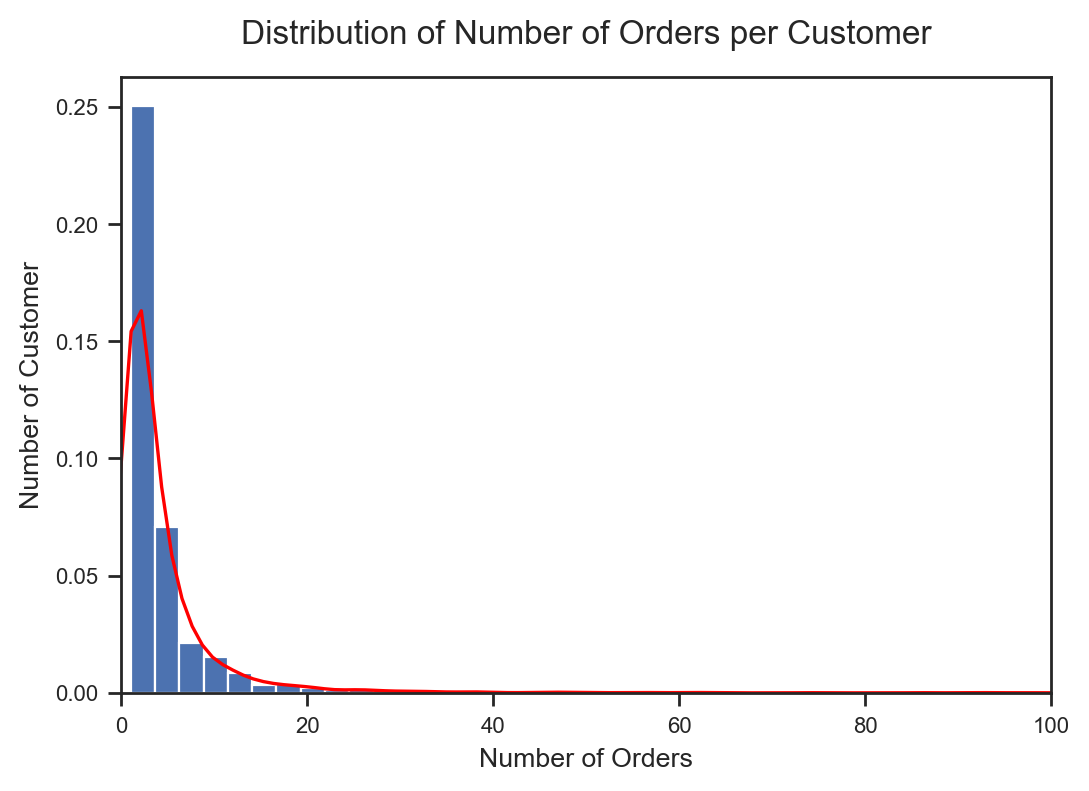

In [840]:
# plotting histogram of number of orders per customers
plt.figure(figsize=(6,4))
ax = sns.distplot(number_orders, bins=80, kde=True, hist=True, hist_kws={'alpha':1})
ax.lines[0].set_color('red')
plt.ylabel('Number of Customer')
plt.xlabel('Number of Orders')
plt.title('Distribution of Number of Orders per Customer', fontsize=12)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlim(0, 100)
plt.show()

In [841]:
# defining a function to get the first day of a month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)  # 1 - first day of each month

In [842]:
# applying the function to get invoice month
df['CurrentMonth'] = df['InvoiceDate'].apply(get_month)
df['CurrentMonth'] = df['CurrentMonth'].dt.strftime('%B %Y')  # change date format from 2010-12-1 to December 2010
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CurrentMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,December 2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,December 2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010


In [843]:
# what are the most purchased products?
df_most_purchased = df.groupby('StockCode')['Quantity'].count().to_frame().sort_values(
    by='Quantity', ascending=False).reset_index().head(10)
df_most_purchased.rename(columns={'Quantity': 'TotalOrders'}, inplace=True)
df_most_purchased.head(10)

,StockCode,TotalOrders
0,85123A,2023
1,22423,1714
2,85099B,1615
3,84879,1395
4,47566,1390
5,20725,1304
6,22720,1152
7,POST,1099
8,23203,1091
9,20727,1078


In [844]:
# identifying top 10 products by sales
prod_list = df_most_purchased.StockCode.to_list()
print(prod_list)

['85123A', '22423', '85099B', '84879', '47566', '20725', '22720', 'POST', '23203', '20727']


In [845]:
# what are the descriptions of these products?
for prod in prod_list:
    print(prod, '     ', df['Description'][df['StockCode'] == prod].head(1).to_list()[0])

85123A       WHITE HANGING HEART T-LIGHT HOLDER
22423       REGENCY CAKESTAND 3 TIER
85099B       JUMBO BAG RED RETROSPOT
84879       ASSORTED COLOUR BIRD ORNAMENT
47566       PARTY BUNTING
20725       LUNCH BAG RED RETROSPOT
22720       SET OF 3 CAKE TINS PANTRY DESIGN 
POST       POSTAGE
23203       JUMBO BAG DOILEY PATTERNS
20727       LUNCH BAG  BLACK SKULL.


In [846]:
# active customers in each month
df_customers = df.groupby('CurrentMonth')['CustomerID'].count().to_frame().reset_index()  # convert the   result to dataframe and reset index to convert index (InvoiceMonth) to a column
df_customers.rename(columns={'CustomerID': 'CustomerCounts'}, inplace=True)
df_customers = df_customers.set_index('CurrentMonth')  # set column Month as index
# using index, reorder rows based on the months (December 2010 to December 2011)
df_customers = df_customers.loc[[ "December 2010","January 2011","February 2011","March 2011","April 2011",
                                 "May 2011", "June 2011","July 2011", "August 2011", "September 2011",
                                 "October 2011", "November 2011", "December 2011" ]]
df_customers = df_customers.reset_index() # revert InvoiceMonth as a column
df_customers

,CurrentMonth,CustomerCounts
0,December 2010,25673
1,January 2011,20991
2,February 2011,19707
3,March 2011,26872
4,April 2011,22435
5,May 2011,28075
6,June 2011,26926
7,July 2011,26582
8,August 2011,26796
9,September 2011,39671


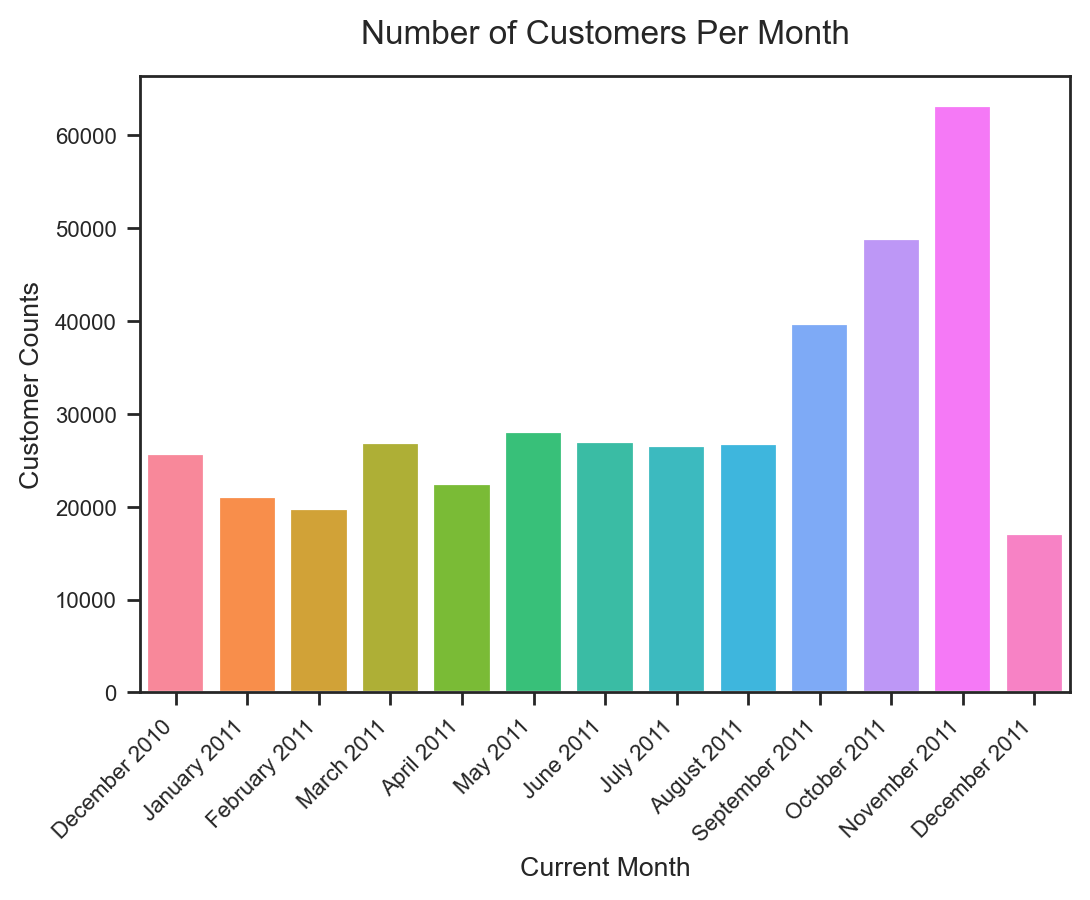

In [847]:
# plotting the number of active customer in each month
plt.figure(figsize=(6,4))
sns.barplot(x='CurrentMonth', y='CustomerCounts', data=df_customers, saturation=1.0)
plt.ylabel('Customer Counts')
plt.xlabel('Current Month')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Number of Customers Per Month', fontsize=12)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [848]:
# finding the highest customer activity
print('Largest number of customers by month: ', df_customers['CustomerCounts'].max())
print('Highest Month by Customers: ', df_customers.iloc[df_customers['CustomerCounts'].idxmax()]['CurrentMonth'])
# df_customers['Month'].values[df_customers['CustomerCounts'].idxmax()]
# df_customers._get_value(df_customers['CustomerCounts'].idxmax(), 'Month')  # get the month given the index value and the cloumn name

# finding the lowest customer activity
print('Lowest number of customers by month: ', df_customers['CustomerCounts'].min())
print('Lowest Month by Customers: ', df_customers.iloc[df_customers['CustomerCounts'].idxmin()]['CurrentMonth'])

# finding the average customer activity
print('Average number of customers by year: ', df_customers['CustomerCounts'].mean().round(1))

Largest number of customers by month:  63182
Highest Month by Customers:  November 2011
Lowest number of customers by month:  17026
Lowest Month by Customers:  December 2011
Average number of customers by year:  30210.2


In [849]:
# finding top 20 customers by their total purchases
df_purchases = df.groupby('CustomerID')['InvoiceDate'].count().to_frame().reset_index()
df_purchases.rename(columns={'InvoiceDate': 'TotalPurchases'}, inplace=True)
df_purchases.sort_values(by='TotalPurchases', ascending=False, inplace=True)
df_top_customers = df_purchases.reset_index(drop=True).head(20)
#df_top_customers

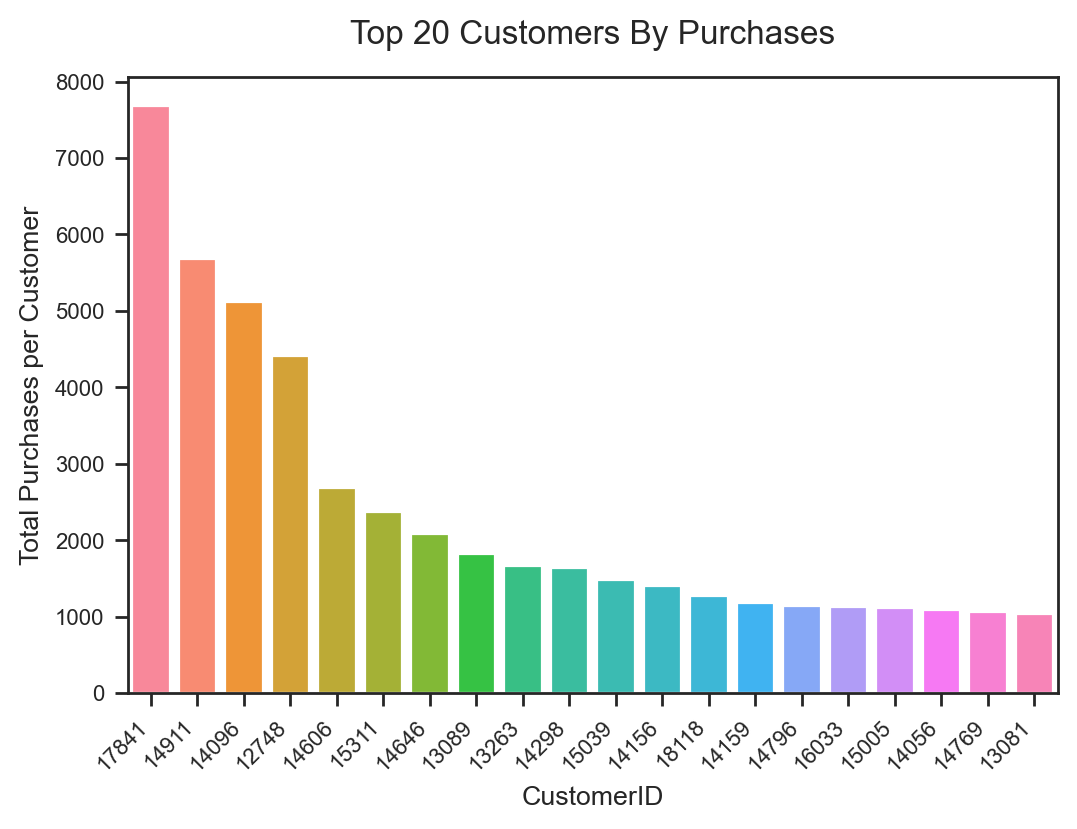

In [850]:
# plot top 20 customers by their purchases
plt.figure(figsize=(6,4))
sns.barplot(x='CustomerID', y='TotalPurchases', data=df_top_customers, 
            order=df_top_customers.sort_values('TotalPurchases', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Purchases per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 20 Customers By Purchases', fontsize=12)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

In [851]:
# finding top 20 customers by their quantity of items purchased
df_quantity = df.groupby('CustomerID')['Quantity'].sum().to_frame().reset_index()
df_quantity.rename(columns={'Quantity': 'TotalQuantity'}, inplace=True)
df_quantity.sort_values(by='TotalQuantity', ascending=False, inplace=True)
df_quantity = df_quantity.reset_index(drop=True).head(20)
#df_quantity

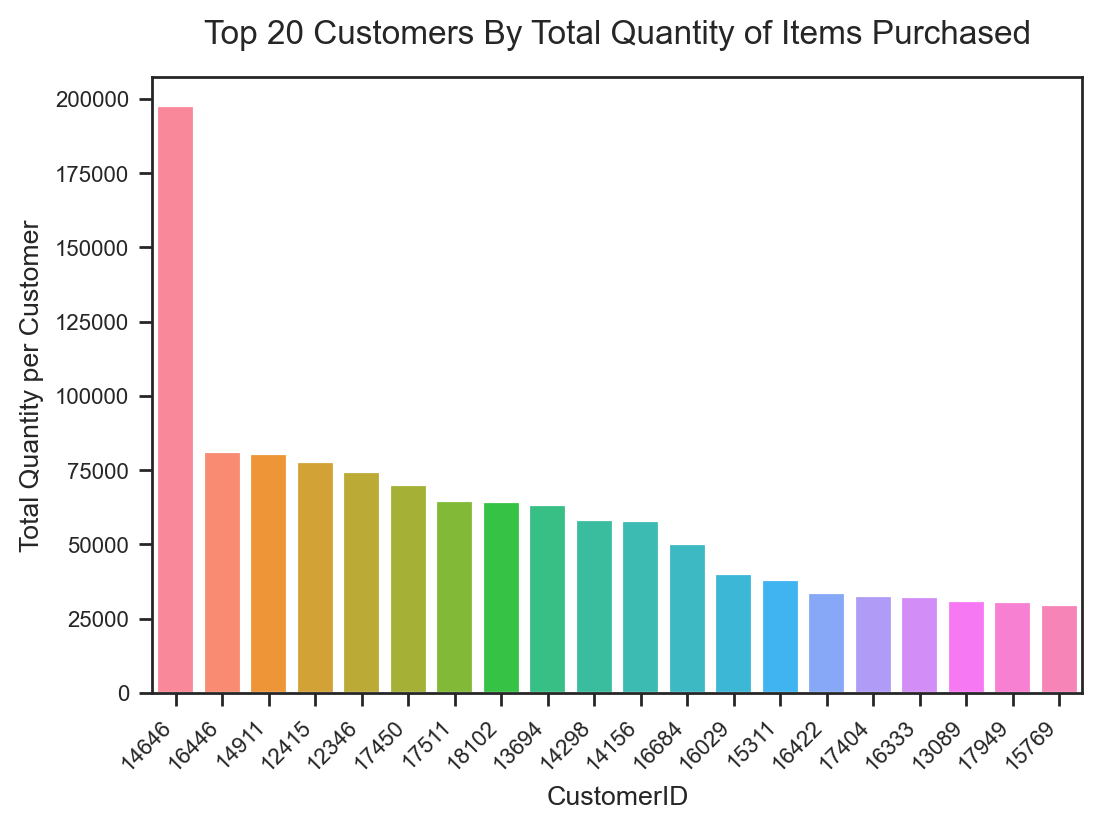

In [852]:
# plot top 20 customers by their quantity of items purchased
plt.figure(figsize=(6,4))
sns.barplot(x='CustomerID', y='TotalQuantity', data=df_quantity, 
            order=df_quantity.sort_values('TotalQuantity', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Quantity per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 20 Customers By Total Quantity of Items Purchased', fontsize=12)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

In [853]:
# top 20 customers by sales
df['Sales'] = df['Quantity'] * df['UnitPrice']
df_sales = df.groupby('CustomerID')['Sales'].sum().to_frame().reset_index()
df_sales.rename(columns={'Sales': 'TotalSales'}, inplace=True)
df_sales.sort_values(by='TotalSales', ascending=False, inplace=True)
df_sales = df_sales.reset_index(drop=True).head(20)
#df_sales

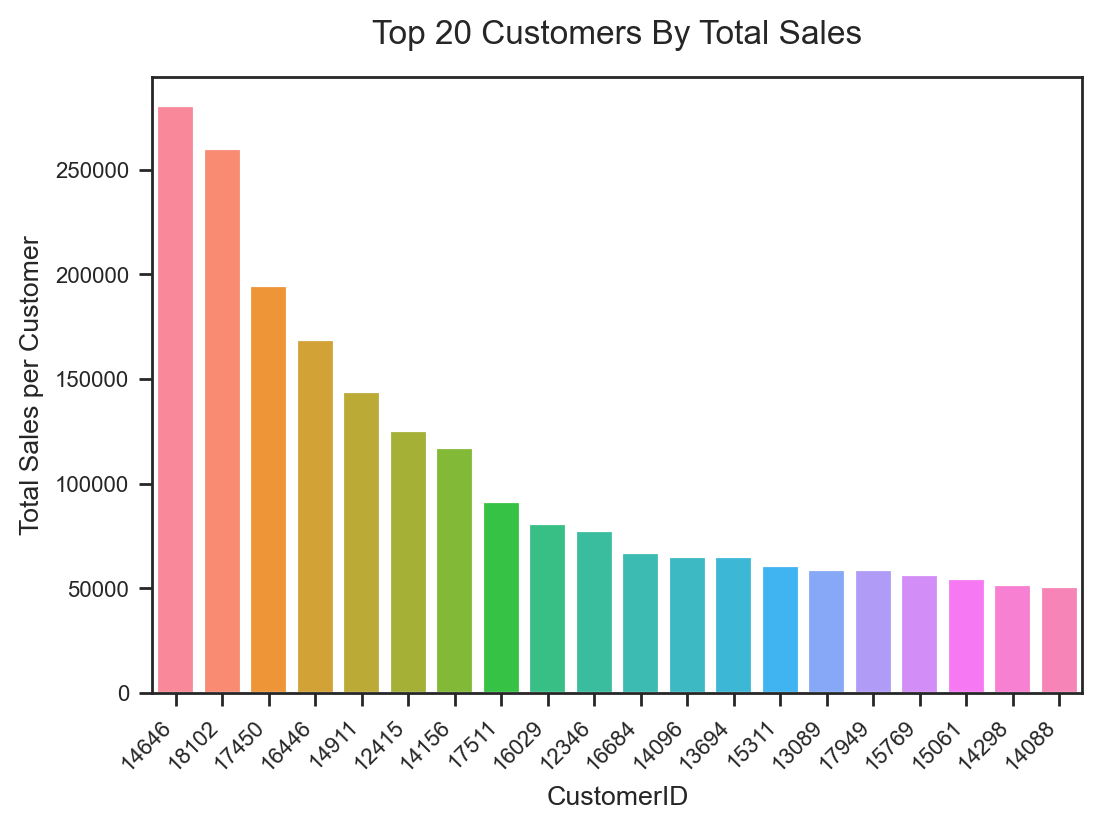

In [854]:
# plot top 20 customers by Sales
plt.figure(figsize=(6,4))
sns.barplot(x='CustomerID', y='TotalSales', data=df_sales, 
            order=df_sales.sort_values('TotalSales', ascending=False)['CustomerID'], saturation=1.0)
plt.ylabel('Total Sales per Customer')
plt.xlabel('CustomerID')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 20 Customers By Total Sales', fontsize=12)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

In [855]:
# top 20 country by customers
df_country_customers = df.groupby('Country')['CustomerID'].count().to_frame().reset_index()
df_country_customers.rename(columns={'CustomerID': 'CustomerCounts'}, inplace=True)
df_country_customers.sort_values(by='CustomerCounts', ascending=False, inplace=True)
df_country_customers = df_country_customers.reset_index(drop=True).head(20)
#df_country_customers

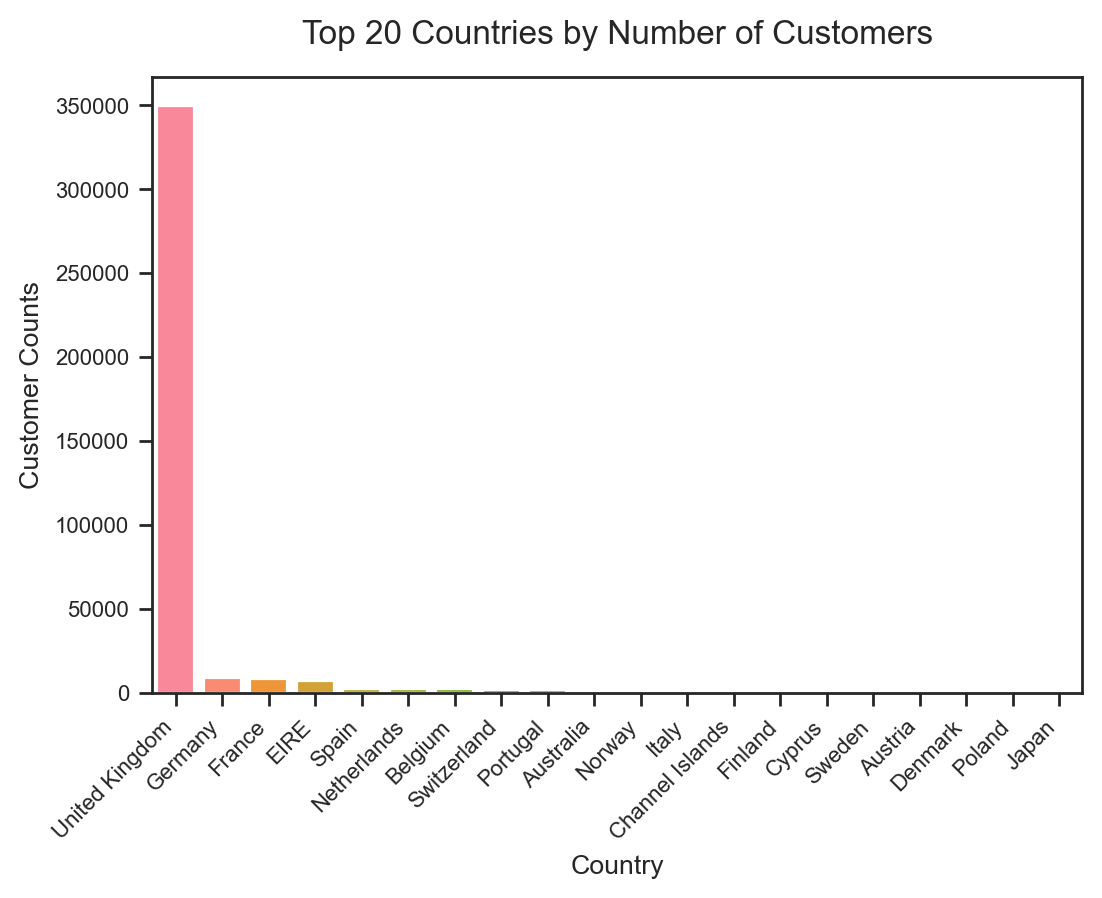

In [856]:
# plotting top 20 countries by customers
plt.figure(figsize=(6,4))
sns.barplot(x='Country', y='CustomerCounts', data=df_country_customers, 
            order=df_country_customers.sort_values('CustomerCounts', ascending=False)['Country'], saturation=1.0)
plt.ylabel('Customer Counts')
plt.xlabel('Country')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 20 Countries by Number of Customers', fontsize=12)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

In [857]:
# top 20 countries by sales
df_country_sales = df.groupby('Country')['Sales'].sum().to_frame().reset_index()
df_country_sales.rename(columns={'Sales': 'TotalSales'}, inplace=True)
df_country_sales.sort_values(by='TotalSales', ascending=False, inplace=True)
df_country_sales = df_country_sales.reset_index(drop=True).head(20)
#df_country_sales

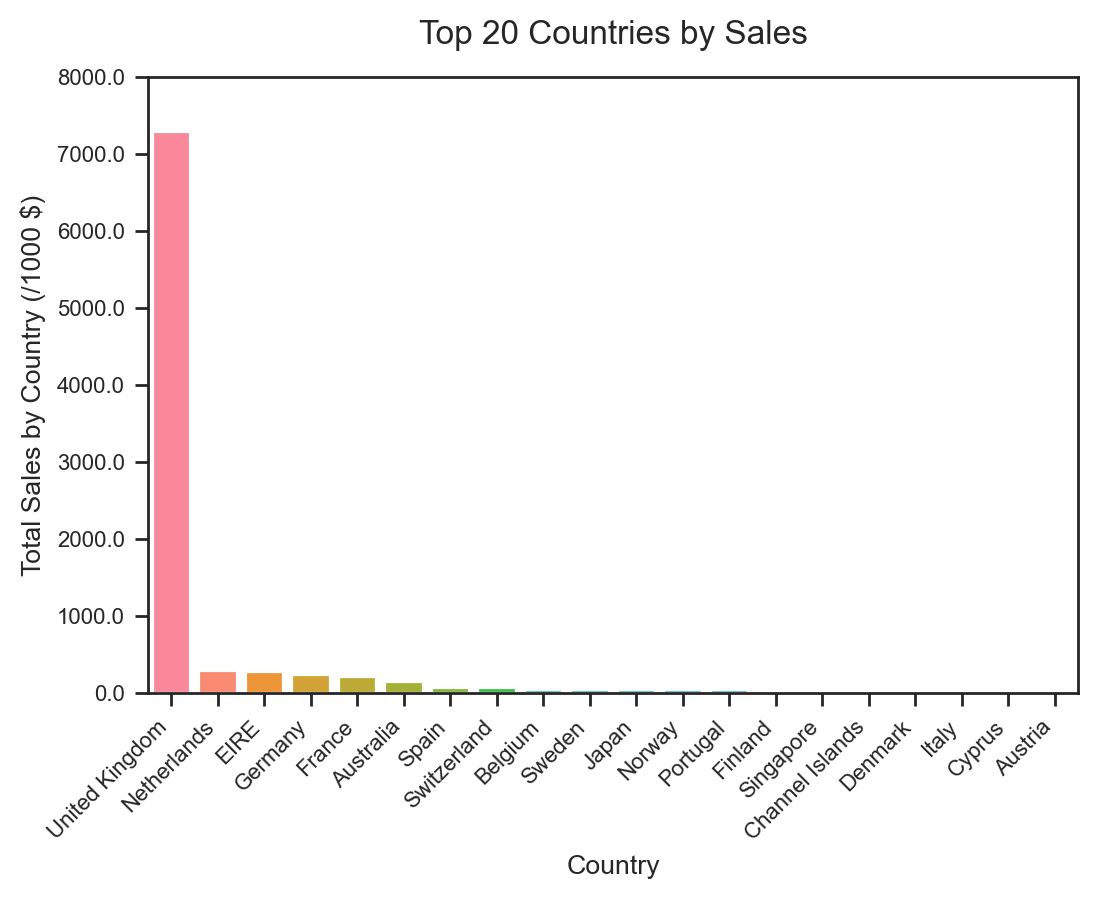

In [858]:
# plotting top 20 countries by customers
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Country', y='TotalSales', data=df_country_sales, 
            order=df_country_sales.sort_values('TotalSales', ascending=False)['Country'], saturation=1.0)
plt.ylabel('Total Sales by Country (/1000 $)')
plt.xlabel('Country')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top 20 Countries by Sales', fontsize=12)
#plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(ax.get_yticks(), ax.get_yticks() / 1000)
plt.show()

## Cohort Analysis

In this section, we perform user cohort retention analysis and relate it with the revenues cohort analysis.

### Customer Retention Rate Cohort Analysis

In [859]:
# get dates in which the customers made the purchases and convert into year and month only
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')
# get a date which each customer made the first purchase and convert into year and month only
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M') 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CurrentMonth,Sales,OrderMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,December 2010,15.30,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,December 2010,22.00,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12


In [860]:
# defining function to calculate cohort index
def compute_cohort_index(df, col1, col2):
    order_year = (df[col1].astype(str).str[:4]).astype('int')
    order_month = (df[col1].astype(str).str[5:]).astype('int')
    cohort_year = (df[col2].astype(str).str[:4]).astype('int')
    cohort_month = (df[col2].astype(str).str[5:]).astype('int')
    #return ((order_year - cohort_year) * 12) + order_month - cohort_month
    return (order_year - cohort_year) * 12 + order_month - cohort_month + 1  # multiplying by 12 to convert year difference into months
# adds 1 to the result in order to start the cohort index at 1 rather than 0 (i.e a transaction made in the same month as the acquisition)

In [861]:
# calculate cohort index
df['CohortIndex'] = compute_cohort_index(df, "OrderMonth", "CohortMonth")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CurrentMonth,Sales,OrderMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,December 2010,15.30,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,December 2010,22.00,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12,2010-12,1


In [862]:
# finding unique number of customers for each cohort month and cohort index
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique()
df_cohort_counts = cohort_counts.to_frame().rename(columns={'CustomerID':'CustomerCounts'}).sort_values(by=['CohortMonth', 'CohortIndex'])
df_cohort_counts

CustomerCounts
CohortMonth CohortIndex                
2010-12     1                       885
            2                       324
            3                       286
            4                       340
            5                       321
...                                 ...
2011-10     2                        86
            3                        41
2011-11     1                       324
            2                        36
2011-12     1                        41

[91 rows x 1 columns]

In [863]:
# find maximum number of customer counts for each month
df_cohort_counts.groupby(["CohortMonth"])["CustomerCounts"].transform("max").to_frame()

CustomerCounts
CohortMonth CohortIndex                
2010-12     1                       885
            2                       885
            3                       885
            4                       885
            5                       885
...                                 ...
2011-10     2                       358
            3                       358
2011-11     1                       324
            2                       324
2011-12     1                        41

[91 rows x 1 columns]

In [864]:
# compute the retention rate for each month by dividing the total number of customers in each index with the highest number of customers in all indexes in that month
df_cohort_counts['RetentionRate'] = (df_cohort_counts['CustomerCounts'] / df_cohort_counts.groupby(["CohortMonth"])["CustomerCounts"].transform("max")).round(2)
df_cohort_counts.sort_values(by=['CohortMonth', 'CohortIndex'])

CustomerCounts  RetentionRate
CohortMonth CohortIndex                               
2010-12     1                       885           1.00
            2                       324           0.37
            3                       286           0.32
            4                       340           0.38
            5                       321           0.36
...                                 ...            ...
2011-10     2                        86           0.24
            3                        41           0.11
2011-11     1                       324           1.00
            2                        36           0.11
2011-12     1                        41           1.00

[91 rows x 2 columns]

In [865]:
# produce the pivot table of the customer counts for each month and cohort index
cohort_pivot = df_cohort_counts.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerCounts')
cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


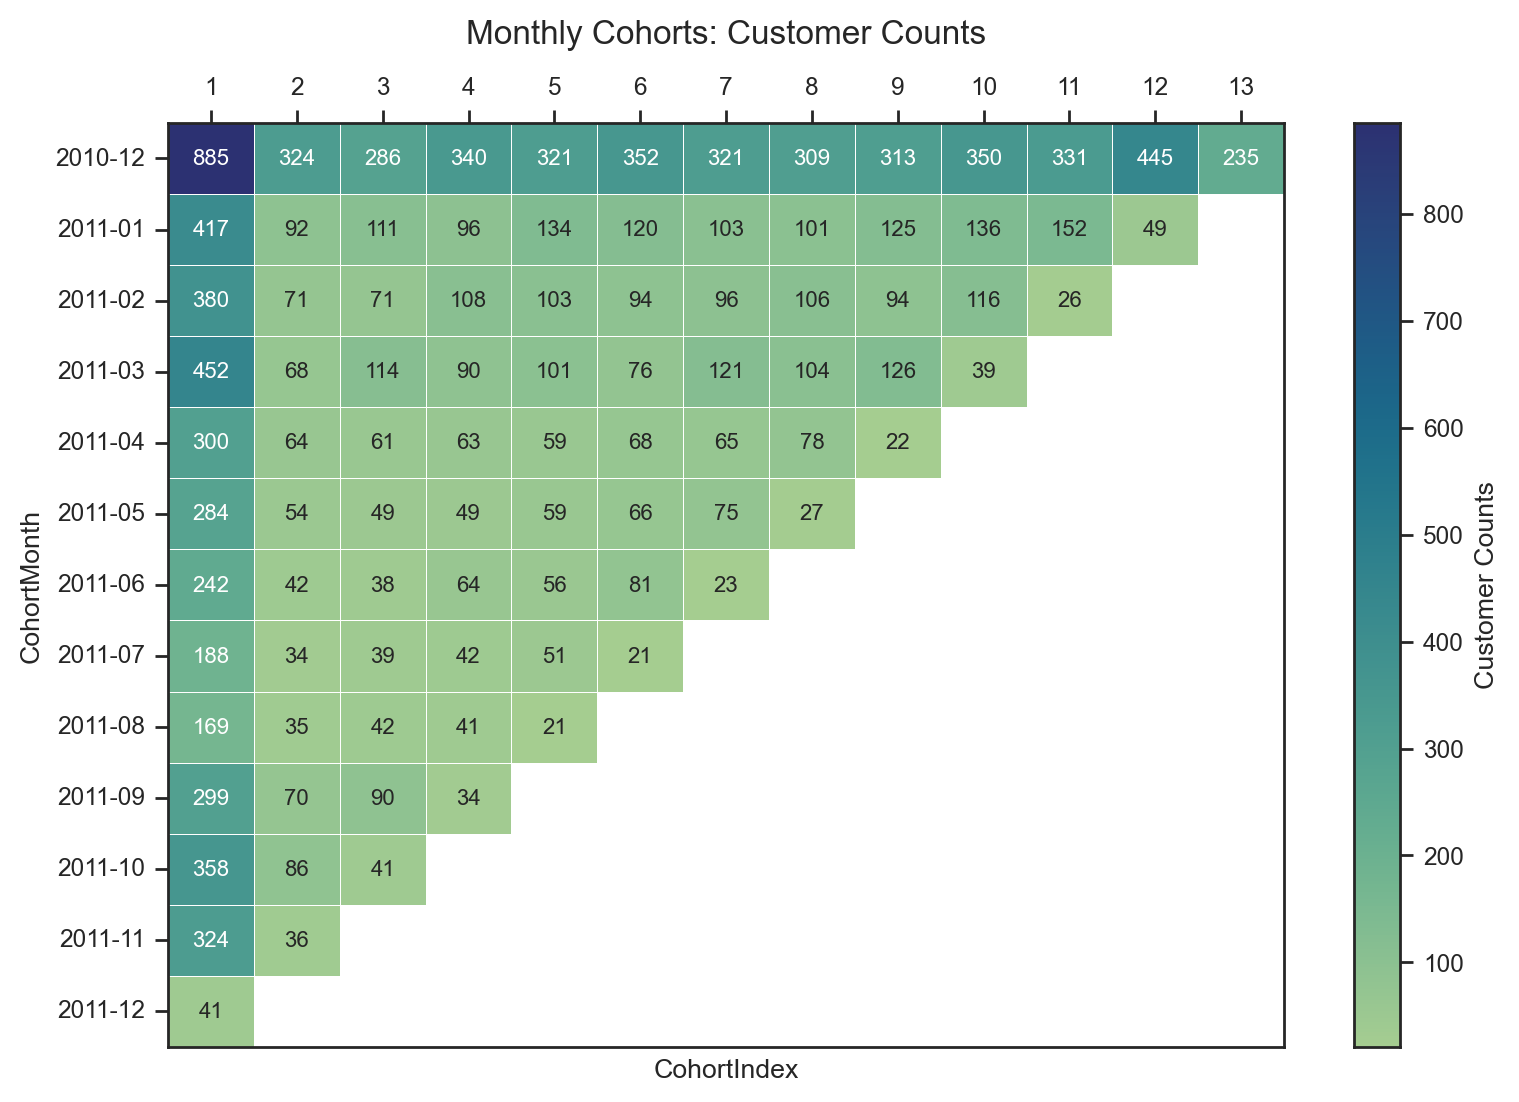

In [866]:
# plotting the retention rate pivot table as a heatmap to observe our monthly recurring customer in percentage 
#sns.set(font_scale=0.9)
plt.figure(figsize=(9,6))
plt.title("Monthly Cohorts: Customer Counts", fontsize=12)
ax = sns.heatmap(data=cohort_pivot, annot=True, fmt='.0f', cmap="crest", linewidth=.3, 
            annot_kws={'size': '8'}, cbar_kws={'label': 'Customer Counts'})
ax.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [867]:
# reproduce the pivot table to show the rate of monthly recurring customer (retention rates)
cohort_pivot_retention = df_cohort_counts.pivot_table(index='CohortMonth', columns='CohortIndex', values='RetentionRate').round(2)
cohort_pivot_retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.37,0.32,0.38,0.36,0.40,0.36,0.35,0.35,0.40,0.37,0.50,0.27
2011-01,1.0,0.22,0.27,0.23,0.32,0.29,0.25,0.24,0.30,0.33,0.36,0.12,NaN
2011-02,1.0,0.19,0.19,0.28,0.27,0.25,0.25,0.28,0.25,0.31,0.07,NaN,NaN
2011-03,1.0,0.15,0.25,0.20,0.22,0.17,0.27,0.23,0.28,0.09,NaN,NaN,NaN
2011-04,1.0,0.21,0.20,0.21,0.20,0.23,0.22,0.26,0.07,NaN,NaN,NaN,NaN
2011-05,1.0,0.19,0.17,0.17,0.21,0.23,0.26,0.10,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.17,0.16,0.26,0.23,0.33,0.10,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.18,0.21,0.22,0.27,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.21,0.25,0.24,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


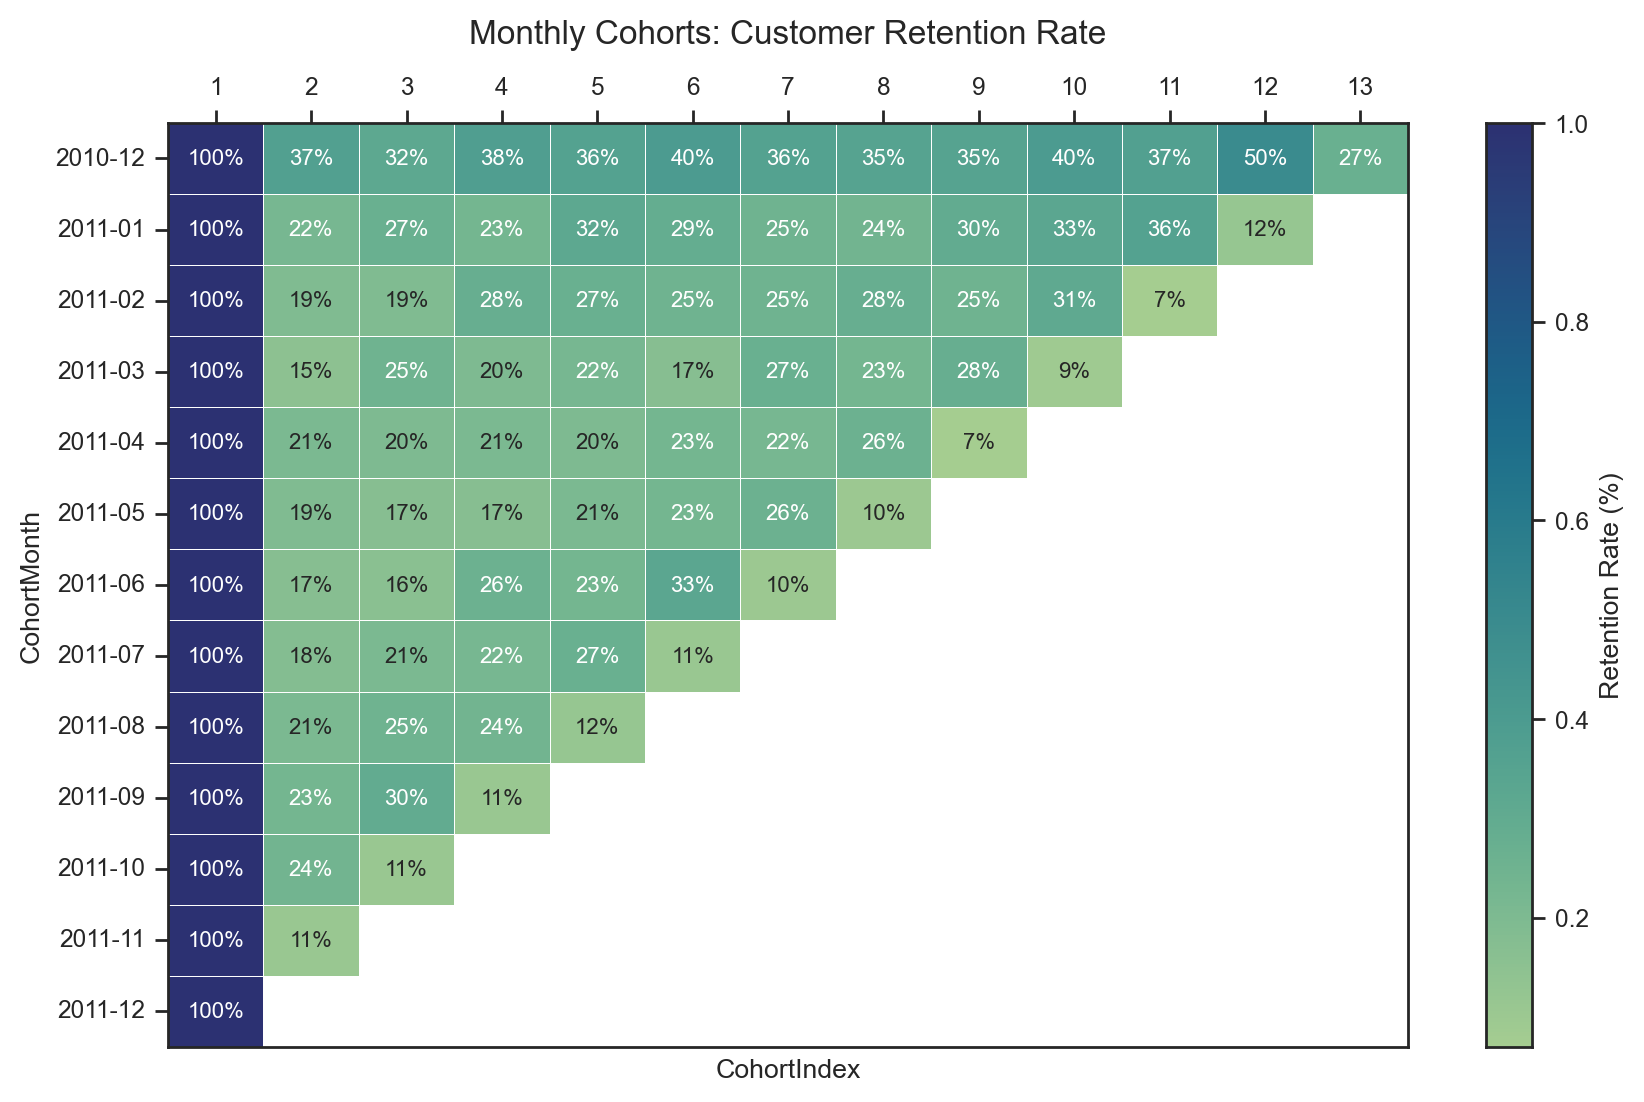

In [868]:
# plotting the retention rate pivot table as a heatmap to observe our monthly recurring customer in percentage 
fig = plt.figure(figsize=(10,6))
plt.title("Monthly Cohorts: Customer Retention Rate", fontsize=12)
ax = sns.heatmap(data=cohort_pivot_retention, annot=True, fmt='.0%', cmap="crest", linewidth=.3, 
            annot_kws={'size': '8'}, cbar_kws={'label': 'Retention Rate (%)'})
ax.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()
fig.savefig('C:/Users/tomna/Desktop/Desktop/Notebooks/E-commerce/Customer_Retention_Rate.png', format='png', dpi=1200)

Several observations can be withdrawn from the heatmap above:
1. The first month (Dec 2010) has exceptionally high recurring customers, up to 50% of customers acquired in this month are still active 12 month later after their acquisition.
2. The retention rate has drastically dropped in the month of Feb, Mar and Nov of 2011, dropping approximately by 80%.
3. Generally, in each month, the number of customers keep coming back to purchase more after a period of time slightly increases, indicating their loyalty or due to improvement of products. However, the behaviour suddenly drops after varying period for each month. For example, customer retention for customers acquired in Jan 2011 was dropped by 10% after 12 months.

### Quantity & Revenue Cohort Analysis

In [869]:
# finding total quantity for each cohort month and cohort index
cohort_quantity = df.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].apply(pd.Series.sum).round(2)
df_cohort_quantity = cohort_quantity.to_frame().rename(columns={'Quantity':'TotalQuantity'}).sort_values(by=['CohortMonth', 'CohortIndex'])
df_cohort_quantity.head()

TotalQuantity
CohortMonth CohortIndex               
2010-12     1                   311063
            2                   158489
            3                   136642
            4                   177175
            5                   131185

In [870]:
# produce the pivot table of total quantity for each month and cohort index
cohort_pivot_quantity = df_cohort_quantity.pivot_table(index='CohortMonth', columns='CohortIndex', values='TotalQuantity')

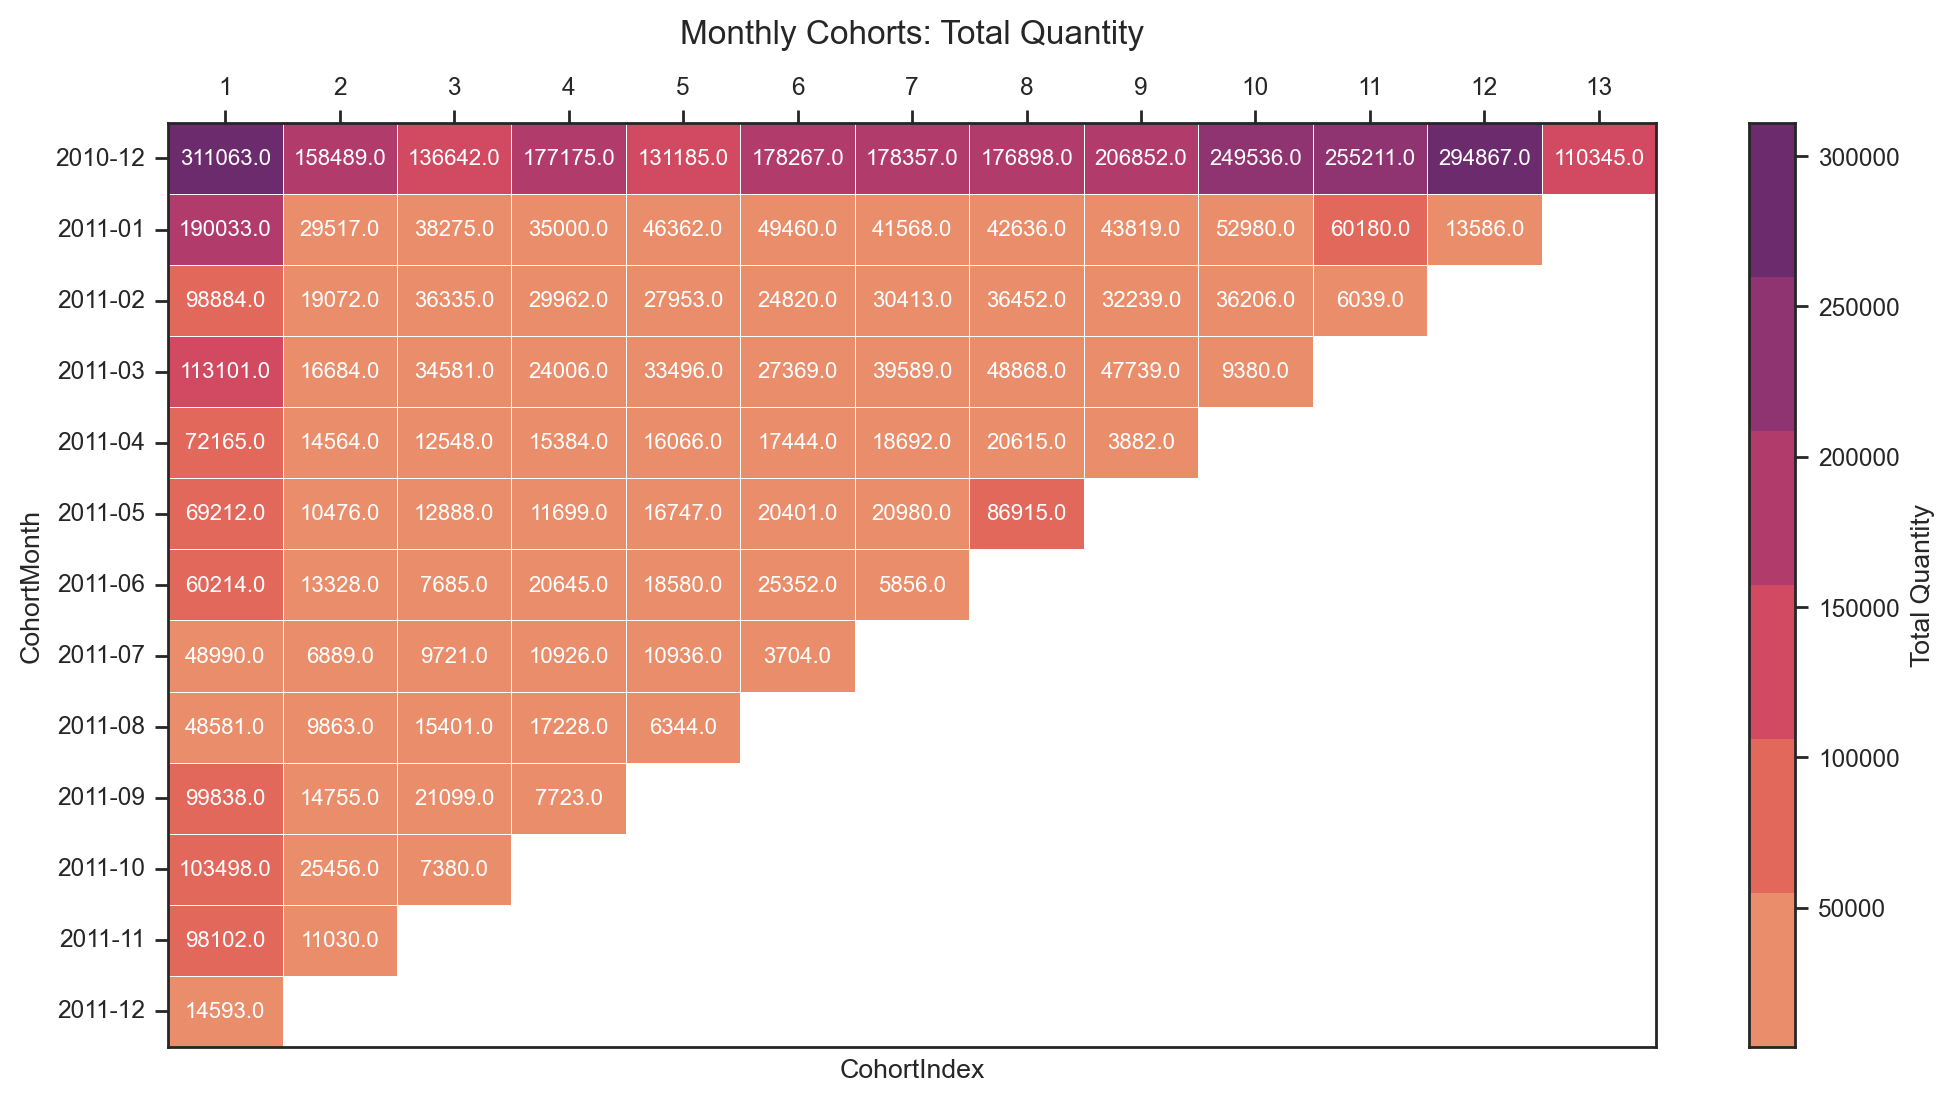

In [871]:
# plotting heatmap of the pivot table 
plt.figure(figsize=(12,6))
plt.title("Monthly Cohorts: Total Quantity", fontsize=12)
ax = sns.heatmap(data=cohort_pivot_quantity, annot=True, fmt='0', cmap=sns.color_palette("flare"), linewidth=.3,
            annot_kws={'size': '8'}, cbar_kws={'label': 'Total Quantity'})
ax.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [872]:
# finding total sales for each cohort month and cohort index
cohort_sales = df.groupby(['CohortMonth', 'CohortIndex'])['Sales'].apply(pd.Series.sum).round(2)
df_cohort_sales = cohort_sales.to_frame().rename(columns={'Sales':'TotalSales'}).sort_values(by=['CohortMonth', 'CohortIndex'])
df_cohort_sales.head()

TotalSales
CohortMonth CohortIndex            
2010-12     1             570422.73
            2             275734.47
            3             233390.47
            4             302367.44
            5             204034.38

In [873]:
# produce the pivot table of total sales for each month and cohort index
cohort_pivot_sales = df_cohort_sales.pivot_table(index='CohortMonth', columns='CohortIndex', values='TotalSales')

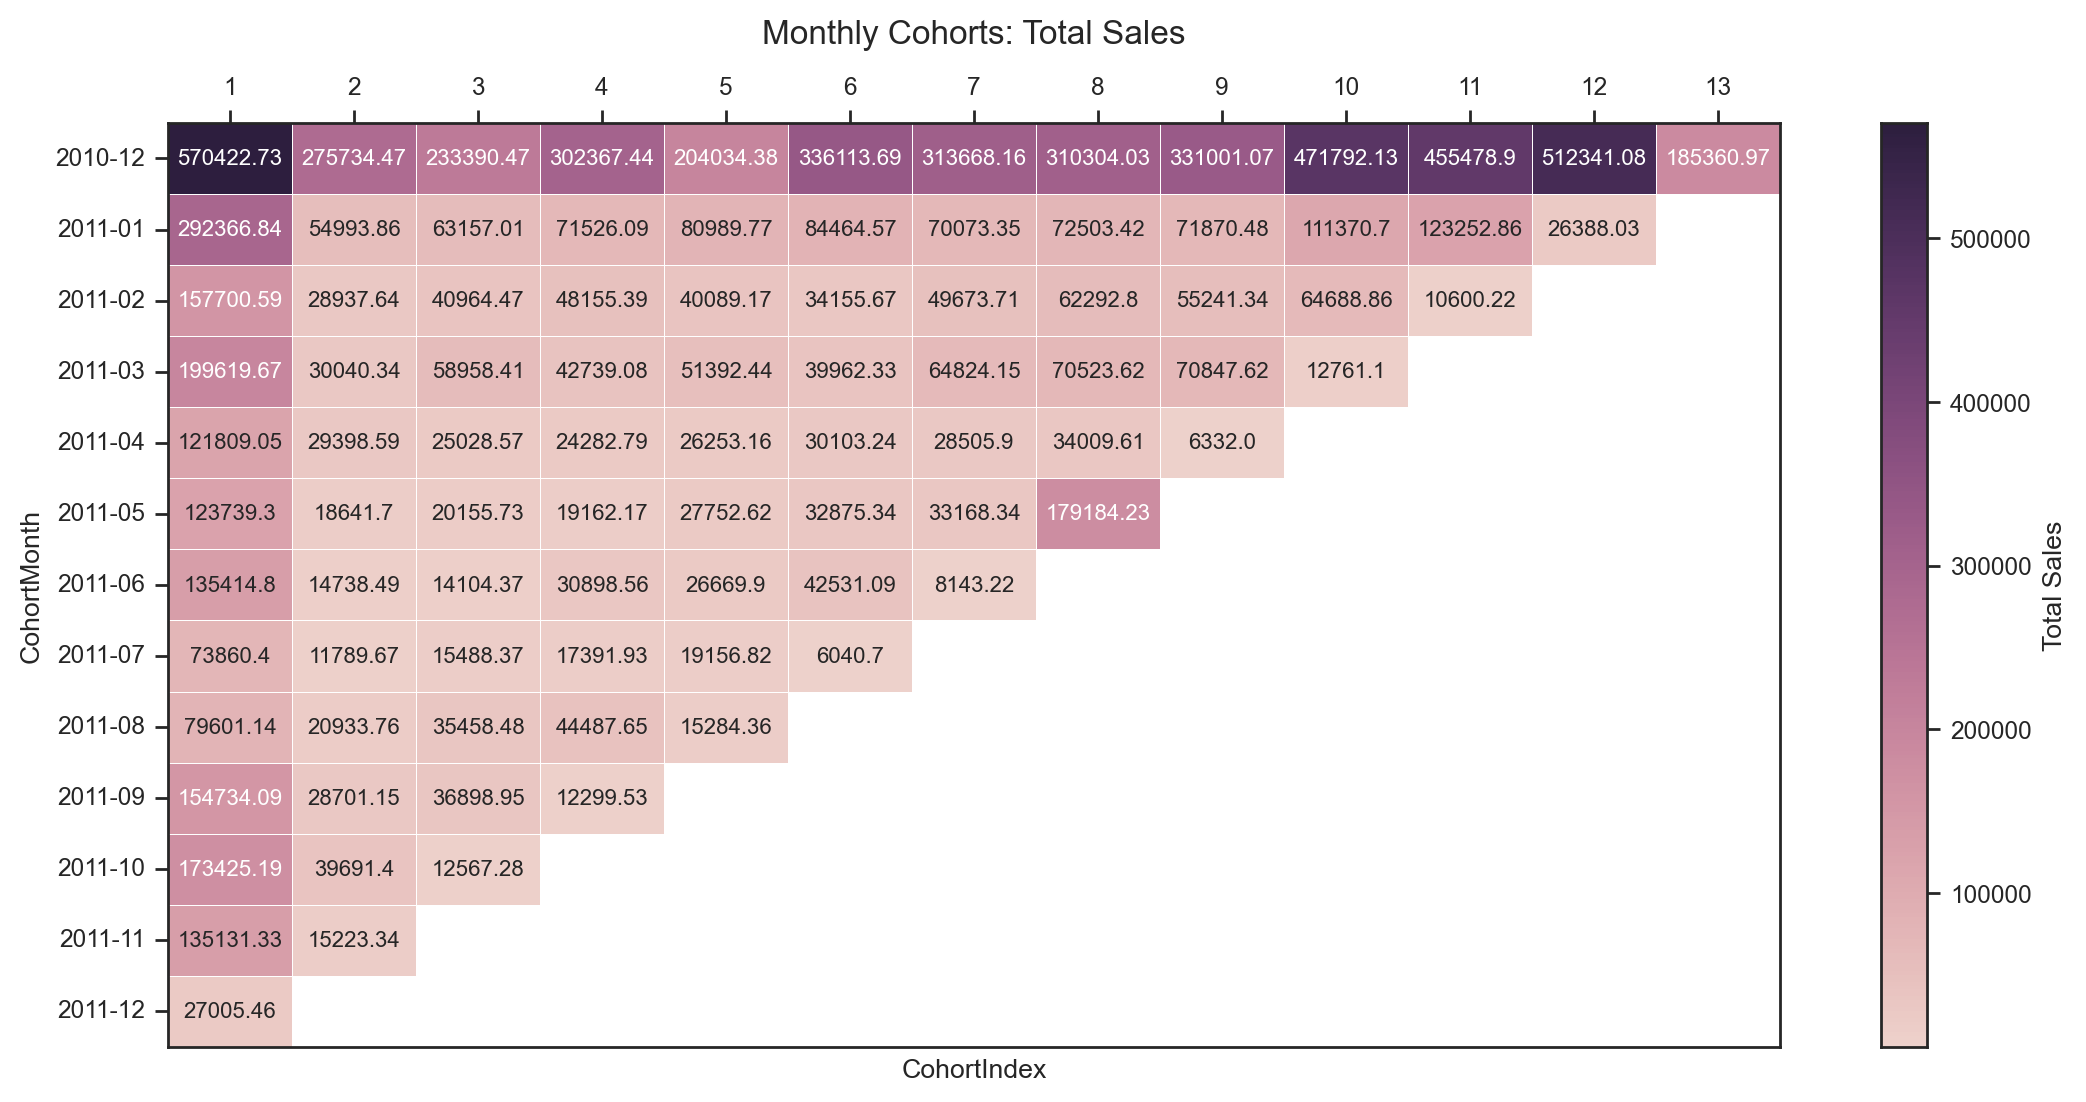

In [874]:
# plotting heatmap of the pivot table 
plt.figure(figsize=(13,6))
plt.title("Monthly Cohorts: Total Sales", fontsize=12)
ax = sns.heatmap(data=cohort_pivot_sales, annot=True, fmt='2', cmap=sns.cubehelix_palette(as_cmap=True), linewidth=.3, 
            annot_kws={'size': '8'}, cbar_kws={'label': 'Total Sales'})
ax.xaxis.tick_top()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

Observations:
1. The total quantity and revenue cohort matrices follow the same patterns as to those shown by the retention matrix, at least for most months. The month Dec 2010 has the highest figures across all indexes.
2. New customers in Dec 2010 bought the most number of items, thus generated the highest revenue. The month generally performed well in terms of revenues compared to others. Stock size sold and the resulting revenue in this month by recurring customer 12 month later is the second to the highest figures recorded in this dataset. 
2. Suprisingly, May 2011 has one of the lowest retention rates but has performed better in terms of sales and revenue compared to other months. This indicates that a few number of customers bought a large number of stock. We analyse this scenario below to confirm this suggestion.

In [875]:
# computing total monthly sales for each customer in a cohort index
df_cust_monthly_sales = df.groupby(['CohortMonth', 'CohortIndex', 'CustomerID'])['Sales'].sum().to_frame()
df_cust_monthly_sales = df_cust_monthly_sales.rename(columns={'Sales': 'TotalMonthlySales'}).sort_values(by=['CohortMonth', 'CohortIndex','TotalMonthlySales'], ascending=False)
df_cust_monthly_sales

TotalMonthlySales
CohortMonth CohortIndex CustomerID                   
2011-12     1           16000                12393.70
                        15195                 3861.00
                        12713                  848.55
                        12478                  680.99
                        15773                  635.68
...                                               ...
2010-12     1           18225                   30.00
                        17888                   29.43
                        17816                   16.21
                        15823                   15.00
                        12476                   12.45

[13055 rows x 1 columns]

In [876]:
# we find top 10 customers for each month in terms of total monthly sales
idx = df_cust_monthly_sales.groupby(['CohortMonth', 'CohortIndex'])['TotalMonthlySales'].transform(max) == df_cust_monthly_sales['TotalMonthlySales']
df_top_monthly_cust = df_cust_monthly_sales[idx].sort_values(by=['TotalMonthlySales'], ascending=False)
df_top_monthly_cust.head(10)

TotalMonthlySales
CohortMonth CohortIndex CustomerID                   
2011-05     8           16446               168469.60
2011-01     1           12346                77183.60
2010-12     10          17450                75412.64
            11          18102                52681.27
            7           18102                41959.44
            9           14646                40327.81
2011-06     1           15098                39916.50
2010-12     6           14646                28408.14
            12          17450                27869.45
            1           18102                27834.61

We can see that there is a customer in May 2011 with cohort index 8 that generated the highest revenue compared to the rest. This confirms our suggestion we highlighted earlier. There are also large spenders in Dec 2010 and Jan 2011 whose revenues have also impacted the total revenues in their respective months as observed in the revenue cohort analysis.

## RFM Analysis 

In [877]:
# picking a random date (after the date of the last sale) for the RFM analysis
today_date = dt.datetime(2012, 1, 5)
today_date

datetime.datetime(2012, 1, 5, 0, 0)

In [878]:
# changing OrderMonth to include the original days
df['OrderMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m-%d')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CurrentMonth,Sales,OrderMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,December 2010,15.30,2010-12-01,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,December 2010,20.34,2010-12-01,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,December 2010,22.00,2010-12-01,2010-12,1


In [879]:
df_rfm = df.groupby('CustomerID').agg({'OrderMonth': lambda x: (today_date - pd.datetime.strptime(x.max(),'%Y-%m-%d')).days,  # calculating difference between the date of analysis and the date of last purchase
                                    'InvoiceNo': 'nunique',  # calculating total number of purchases for each customer (frequency)
                                    'Sales': 'sum'})  # calculating total value of purchases for each customer (monetary)
df_rfm.rename(columns={'OrderMonth': 'Recency', 'InvoiceNo': 'Frequency','Sales': 'Monetary'}, inplace=True)
df_rfm.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346,352,1,77183.60
1,12347,29,7,4310.00
2,12348,102,4,1797.24
3,12349,45,1,1757.55
4,12350,337,1,334.40


In [880]:
# checking if there are negative values in any of the numerical columns
(df_rfm < 0).any()

Recency      False
Frequency    False
Monetary     False
dtype: bool

In [881]:
# checking max and min values of RFM columns
df_rfm.agg({ 'Recency': ['min', 'max'], 'Frequency': ['min', 'max'], 'Monetary': ['min', 'max'] }) 

,Recency,Frequency,Monetary
min,27,1,0.00
max,400,210,280206.02


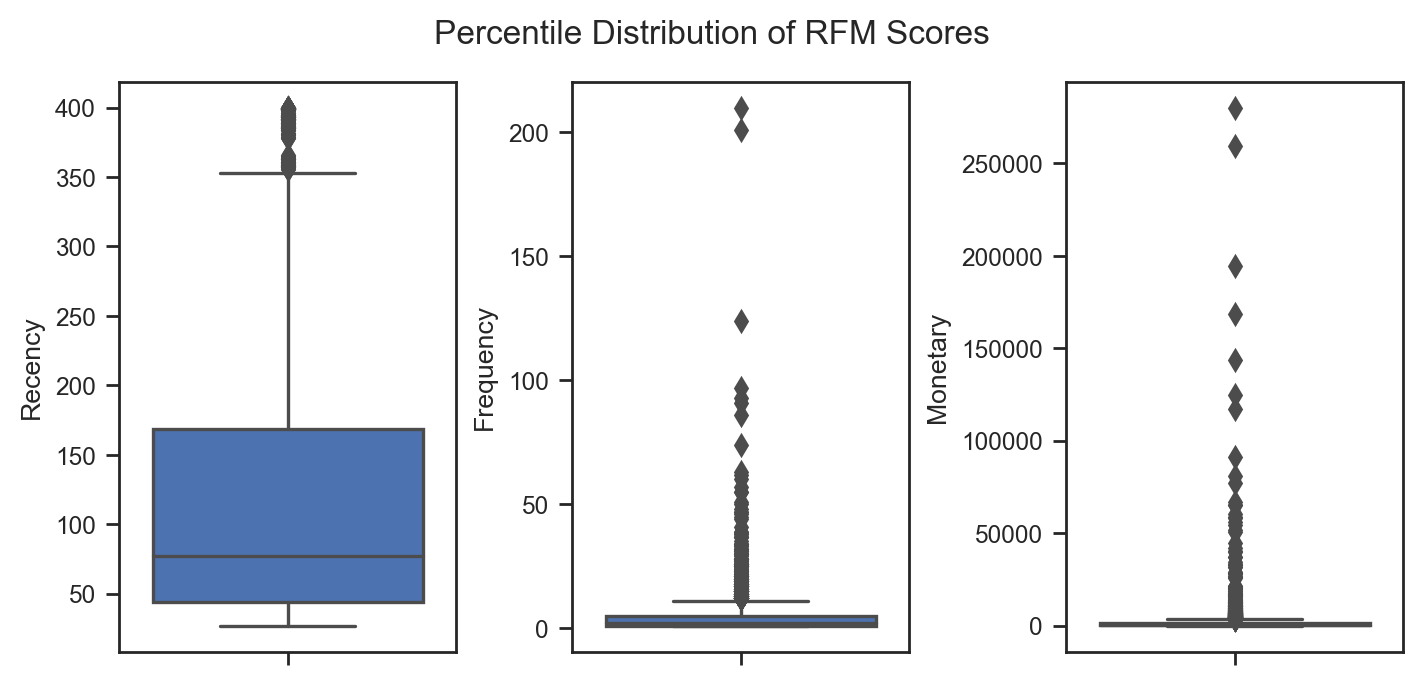

In [882]:
# plotting percentile distribution of RFM scores
cols = ['Recency', 'Frequency', 'Monetary']
fig,axes = plt.subplots(1, len(cols), figsize=(7,3), constrained_layout=True, sharex=False)  
axes = axes.flatten()
for col in cols :
    sns.boxplot(y=df_rfm[col], ax=axes[cols.index(col)], saturation=1.0)
plt.suptitle("Percentile Distribution of RFM Scores", fontsize=12, y=1.09)
plt.show()

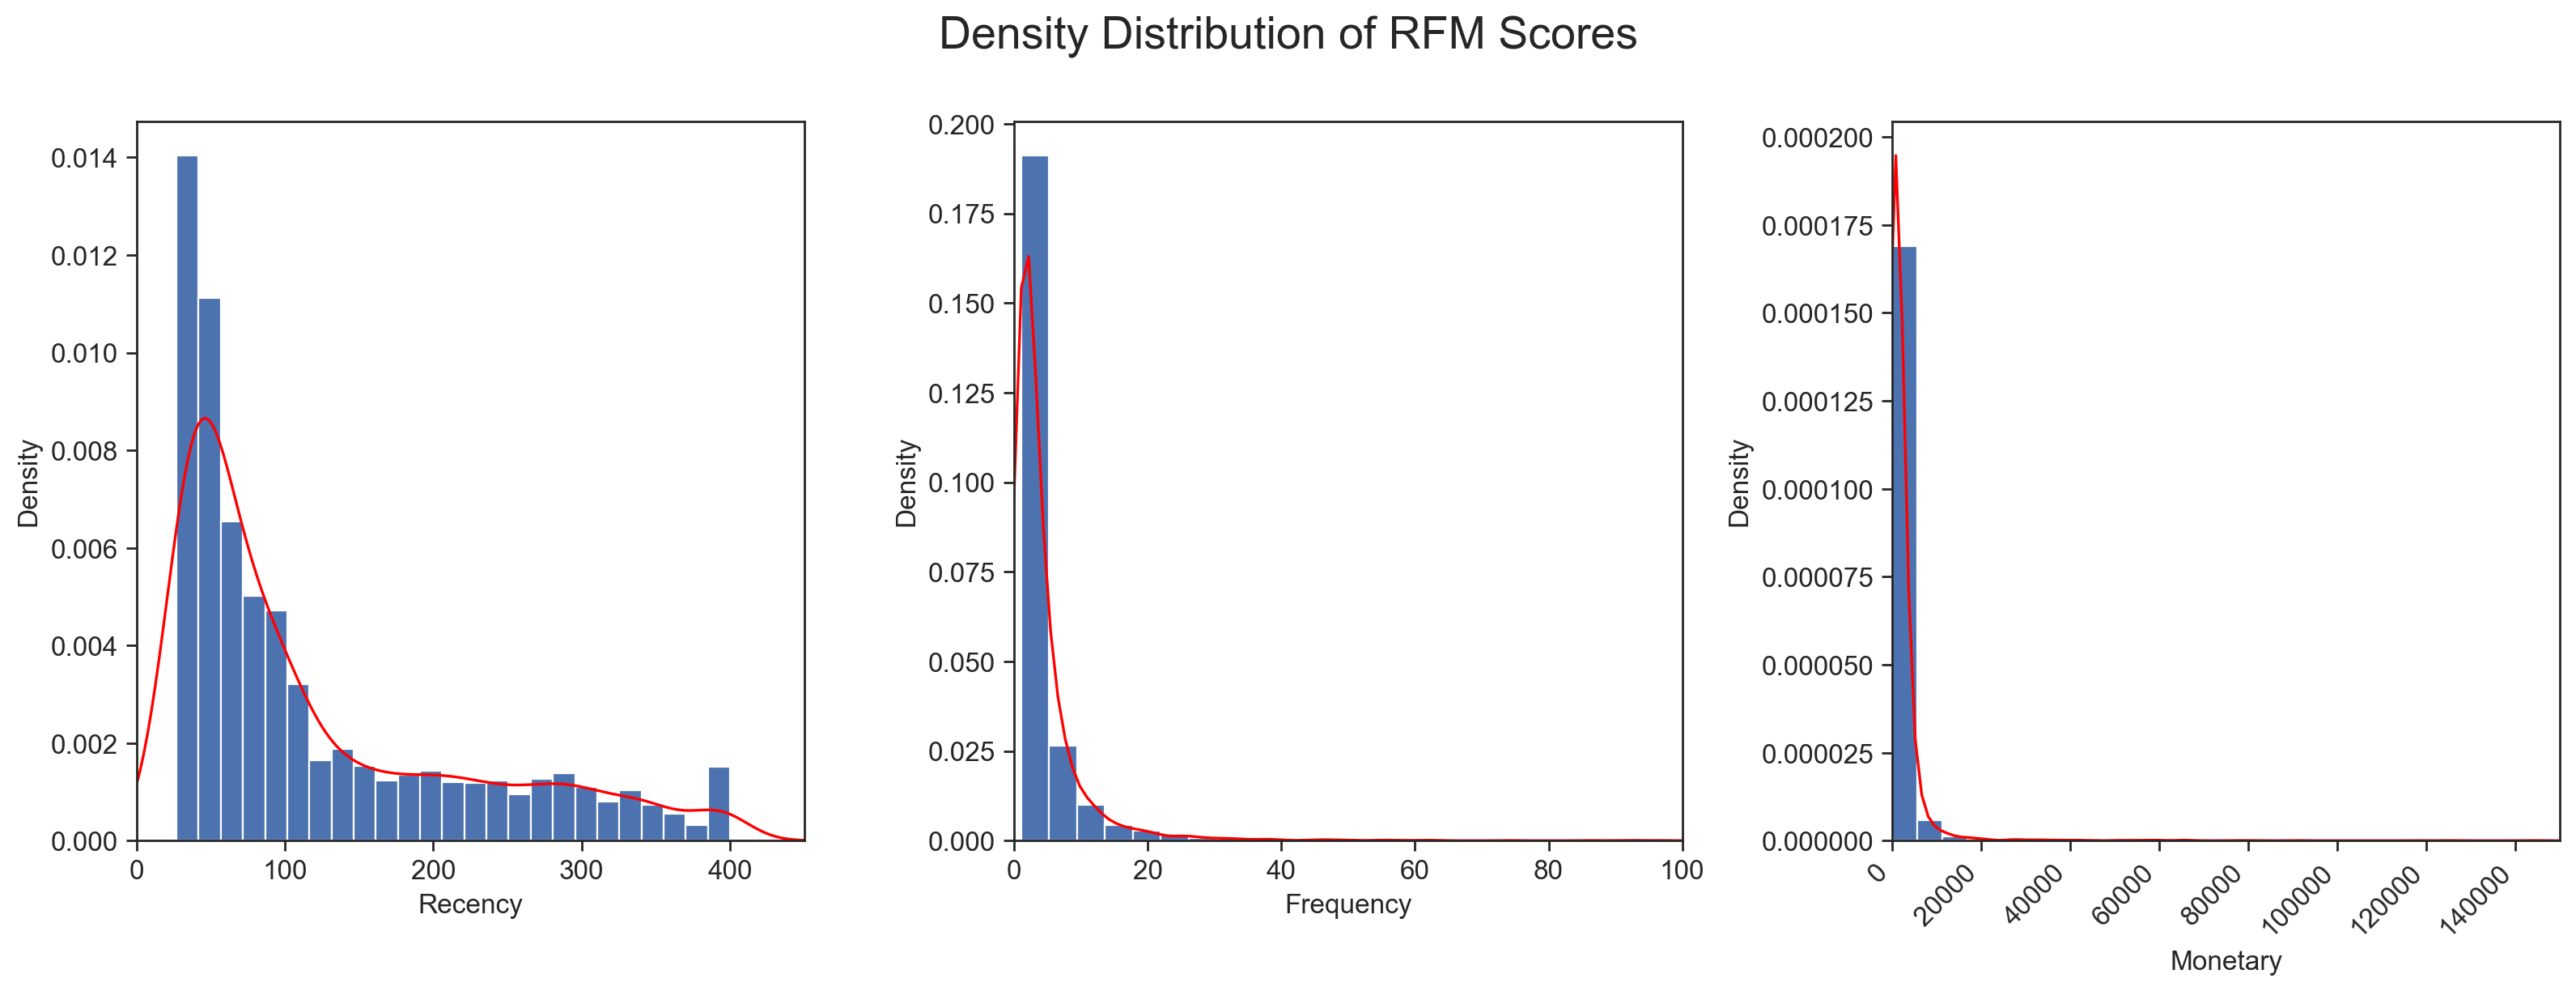

In [883]:
# plotting density distribution of RFM scores 
#sns.set(font_scale=1.0)
plt.figure(figsize = (16, 6))
subplot_num = 1
cols = ['Recency', 'Frequency', 'Monetary']
for col in cols:
    if subplot_num <= len(cols):
        plt.subplot(1, 3, subplot_num)
        # to draw a kde line with a different color, histogram and density have to be drawn as seprate plots
        ax = sns.distplot(df_rfm[col], kde=True, hist=True, hist_kws={'alpha':1})
        ax.lines[0].set_color('red')
        if col == 'Recency' :
            plt.xlim(0, 450)
        if col == 'Frequency' :
            plt.xlim(0, 100)
        if col == 'Monetary' :
            plt.xlim(0, 150000)
            plt.xticks(rotation=45, horizontalalignment="right")
    subplot_num += 1
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
plt.suptitle("Density Distribution of RFM Scores", fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

In [884]:
# finding top customers by monetary and frequency values
df_rfm.sort_values(by=['Monetary', 'Frequency'], ascending=[False, False], inplace=True)
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646,28,74,280206.02
18102,27,60,259657.30
17450,35,46,194390.79
16446,27,2,168472.50
14911,28,201,143711.17


Building RFM Segments. Giving Recency, Frequency, and Monetary scores individually by dividing them into quartiles then
combining the three ratings to get a RFM segment (as strings)

In [885]:
# binning rfm scores into 3 quantiles
df_quartiles = df_rfm[['Recency','Frequency','Monetary']].quantile(q=[0.25,0.50,0.75])
df_quartiles

,Recency,Frequency,Monetary
0.25,44.0,1.0,306.455
0.50,77.0,2.0,668.560
0.75,168.5,5.0,1660.315


In [886]:
# creating a binning function for each metric, 1 being the lowest and 4 the highest
def recency_score(x): 
    if x <= df_quartiles.loc[0.25,'Recency']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Recency']) and (x <= df_quartiles.loc[0.50,'Recency']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Recency']) and (x <= df_quartiles.loc[0.75,'Recency']):
        return 3
    else:
        return 4
    
def frequency_score(x): 
    if x <= df_quartiles.loc[0.25,'Frequency']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Frequency']) and (x <= df_quartiles.loc[0.50,'Frequency']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Frequency']) and (x <= df_quartiles.loc[0.75,'Frequency']):
        return 3
    else:
        return 4
    
def monetary_score(x): 
    if x <= df_quartiles.loc[0.25,'Monetary']:
        return 1
    elif (x > df_quartiles.loc[0.25,'Monetary']) and (x <= df_quartiles.loc[0.50,'Monetary']):
        return 2
    elif (x > df_quartiles.loc[0.50,'Monetary']) and (x <= df_quartiles.loc[0.75,'Monetary']):
        return 3
    else:
        return 4

In [887]:
# Calculating RFM scores
df_rfm['Recency_Score'] = df_rfm['Recency'].apply(recency_score)
df_rfm['Frequency_Score'] = df_rfm['Frequency'].apply(frequency_score)
df_rfm['Monetary_Score'] = df_rfm['Monetary'].apply(monetary_score)
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
CustomerID,,,,,,
14646,28,74,280206.02,1,4,4
18102,27,60,259657.30,1,4,4
17450,35,46,194390.79,1,4,4
16446,27,2,168472.50,1,2,4
14911,28,201,143711.17,1,4,4


In [888]:
df_rfm['Recency_Score'].value_counts()

1    1104
4    1085
3    1077
2    1073
Name: Recency_Score, dtype: int64

In [889]:
df_rfm['RFM_Segment'] = df_rfm['Recency_Score'].astype(str) + df_rfm['Frequency_Score'].astype(str) + df_rfm['Monetary_Score'].astype(str)
df_rfm['RFM_Score'] = df_rfm['Recency_Score'].astype(int) + df_rfm['Frequency_Score'].astype(int) + df_rfm['Monetary_Score'].astype(int)
df_rfm.sort_values(by='RFM_Segment', ascending=False).head(5)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
13093,302,8,7832.47,4,4,4,444,12
15379,196,7,3703.29,4,4,4,444,12
15235,244,12,2247.51,4,4,4,444,12
16919,183,11,2592.25,4,4,4,444,12
18260,199,6,2628.35,4,4,4,444,12


In [890]:
# identifying max and min values of RFM_Segment and RFM_Score
df_rfm.agg({ 'RFM_Segment': ['min', 'max'], 'RFM_Score': ['min', 'max'] }) 

,RFM_Segment,RFM_Score
min,111,3
max,444,12


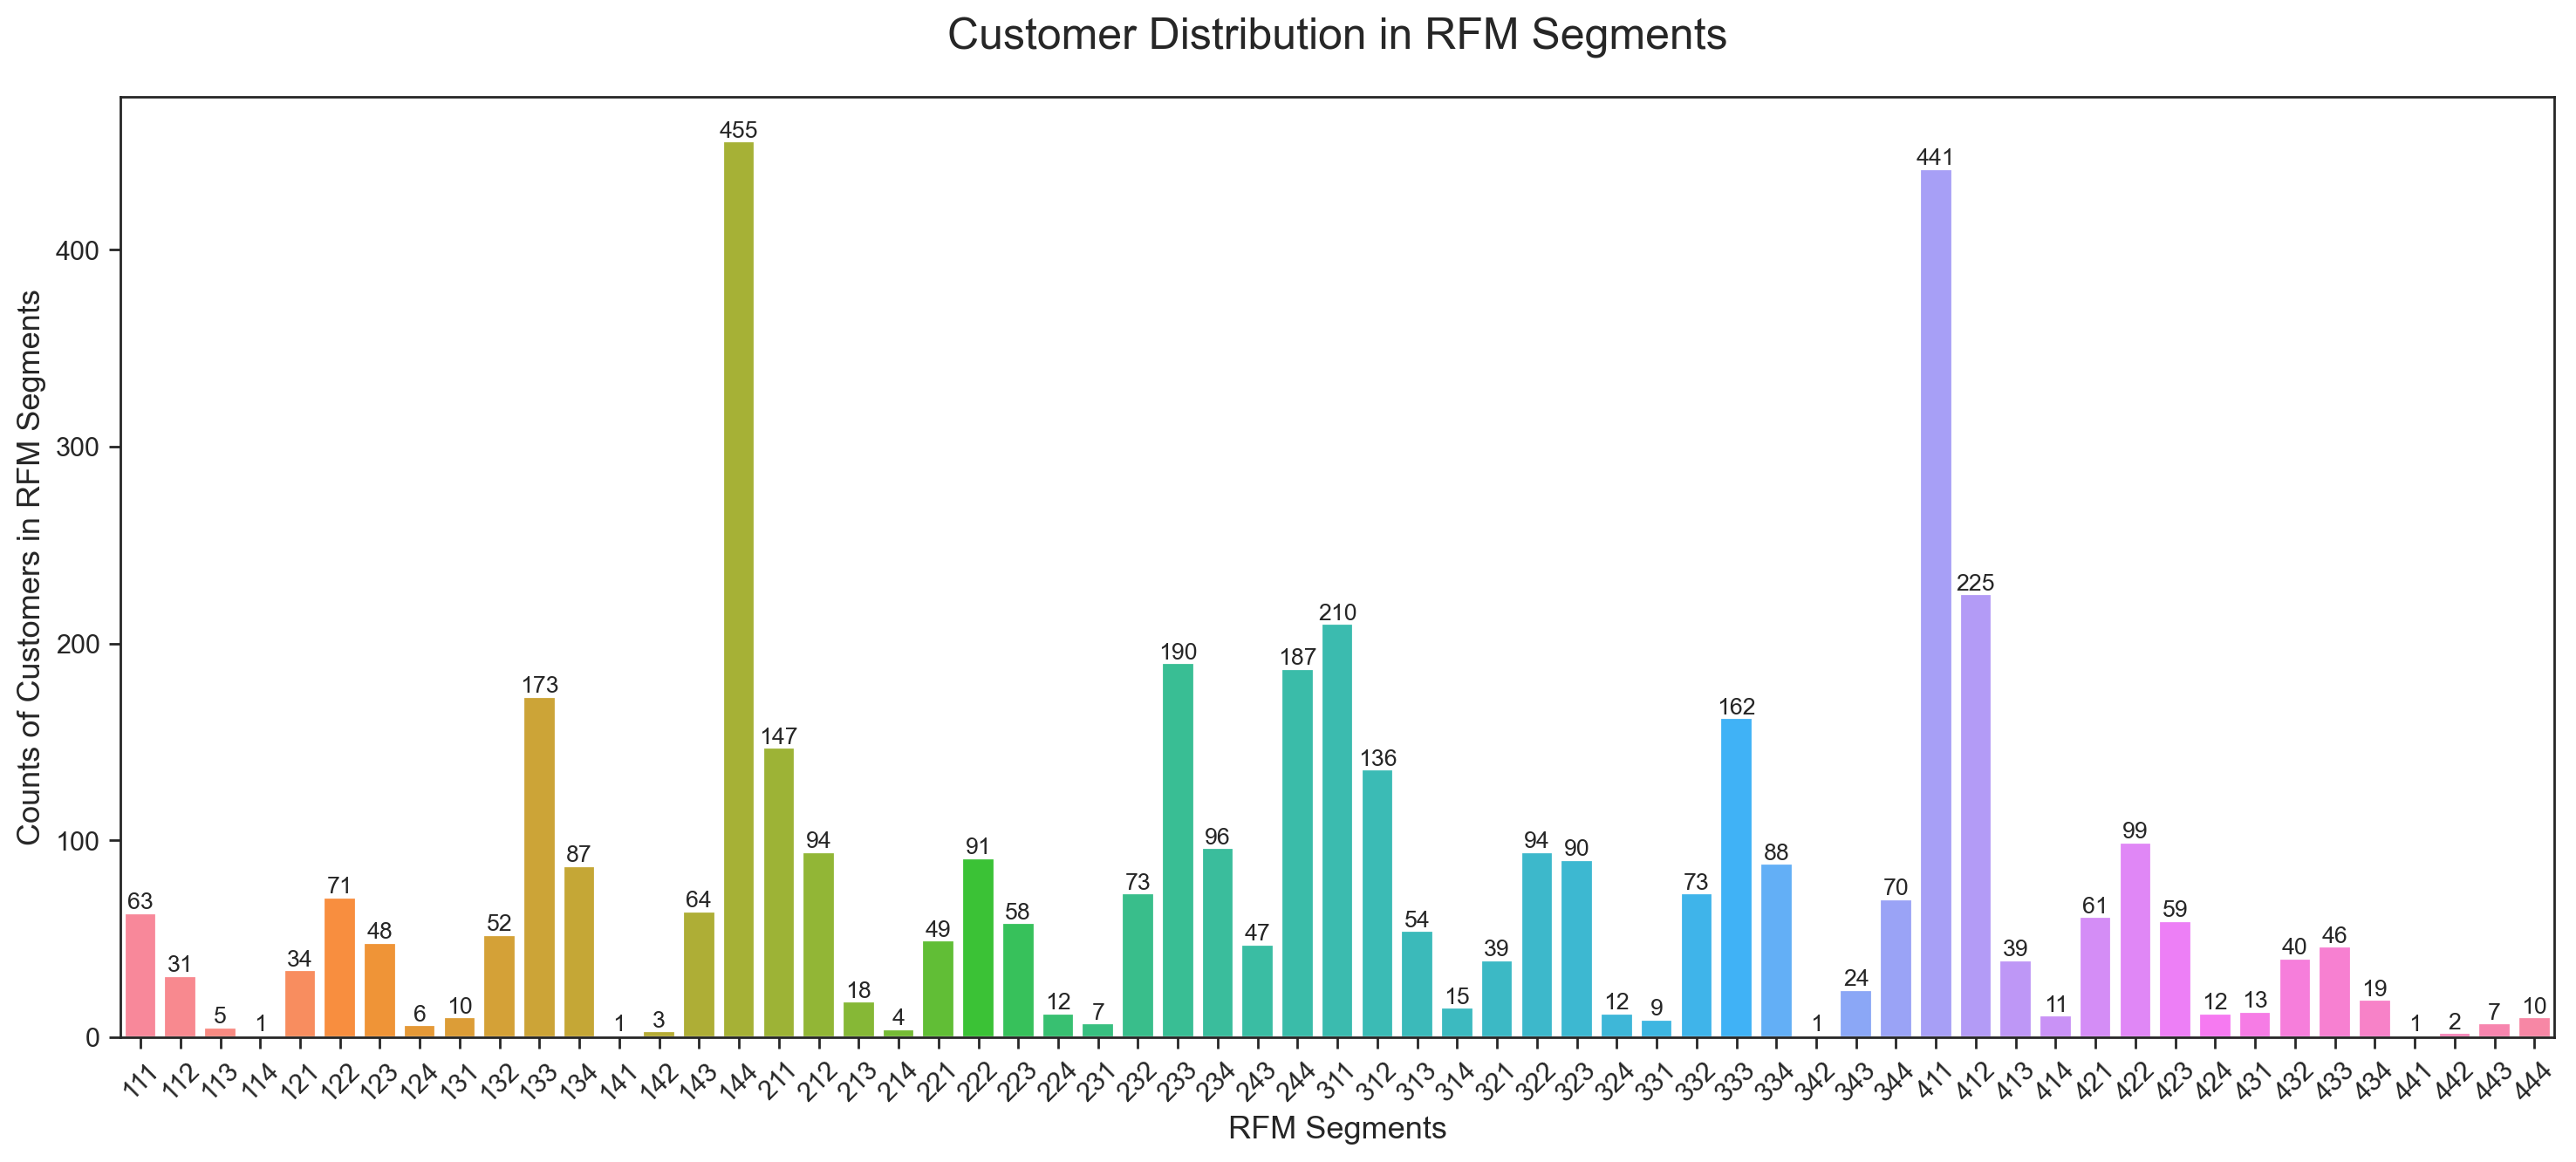

In [891]:
# plot counts of each RFM_Segment
fig, ax = plt.subplots(figsize=(18, 7))
ax = sns.countplot(data=df_rfm.sort_values(by='RFM_Segment'), x='RFM_Segment', saturation=1.0)
ax.bar_label(ax.containers[0])  # display figures on top of bars
plt.title("Customer Distribution in RFM Segments", fontsize=18, y=1.02)
plt.xlabel('RFM Segments', fontsize=13)
plt.ylabel('Counts of Customers in RFM Segments', fontsize=13)
plt.xticks(rotation=45)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.show()
fig.savefig('C:/Users/tomna/Desktop/Desktop/Notebooks/E-commerce/Distribution_of_RFM_Segments.png', format='png', dpi=1200)

Observations:
1) We have all types of classes of customers ranging from the best customers to the churned customers. The best customers, who are transacted recently, do so often and spend more than other customers (here classified as 4-4-4) represents a small percentage of the entire customers set (there are only 10 customers). To retain these customers, marketing communications with this group should make them feel valued and appreciated. Keeping them happy should be a top priority.
2) We also see a significant representation of high-spending new customers. This group consists of those customers in 4-1-4 and 4-1-3. These are customers who transacted only once, but very recently and they spent a lot. In this case we have 50 customers.A marketing strategy with this group is to make them feel valued and appreciated and to give them terrific incentives to continue interacting with the brand. 
3) A small number of lowest-spending active loyal customers are observed. This group consists of those customers in segments 4-4-1 and 4-4-2 (they transacted recently and do so often, but spend the least). Here, we have only 3 customers. Marketers should create campaigns for this group that make them feel valued and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks. 
4) We observe one of the largest classes of customers, churned best customers. This segment consists of those customers in groups 1-4-4, 1-4-3, 1-3-4 and 1-3-3 (they transacted frequently and spent a lot, but it’s been a long time since they have transacted). In this case we have 778 customers. While it’s often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data. 

In [892]:
# defining a new classification of customers based on their RFM scores
def customer_ranking(a): 
    if  (a <= 4):
        return 'Low Tier Customer'    
    elif (a > 4) and (a <= 8):       
        return 'Mid Tier Customer'
    else:
        return 'High Tier Customer'

In [893]:
# creating a column of customer classifition based on their RFM scores
df_rfm['Customer_Class'] = df_rfm['RFM_Score'].apply(customer_ranking)
df_rfm.head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score,Customer_Class
CustomerID,,,,,,,,,
14646,28,74,280206.02,1,4,4,144,9,High Tier Customer
18102,27,60,259657.30,1,4,4,144,9,High Tier Customer
17450,35,46,194390.79,1,4,4,144,9,High Tier Customer
16446,27,2,168472.50,1,2,4,124,7,Mid Tier Customer
14911,28,201,143711.17,1,4,4,144,9,High Tier Customer
12415,51,21,124914.53,2,4,4,244,10,High Tier Customer
14156,36,55,117210.08,1,4,4,144,9,High Tier Customer
17511,29,31,91062.38,1,4,4,144,9,High Tier Customer
16029,65,63,80850.84,2,4,4,244,10,High Tier Customer


In [894]:
# top 10 high tier customers by RFM score
df_rfm[df_rfm['Customer_Class'] == 'High Tier Customer'].sort_values(by=['RFM_Score'], ascending=False).head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score,Customer_Class
CustomerID,,,,,,,,,
13093,302,8,7832.47,4,4,4,444,12,High Tier Customer
15235,244,12,2247.51,4,4,4,444,12,High Tier Customer
17850,399,34,5391.21,4,4,4,444,12,High Tier Customer
12980,184,9,7374.90,4,4,4,444,12,High Tier Customer
17504,233,9,2997.03,4,4,4,444,12,High Tier Customer
15379,196,7,3703.29,4,4,4,444,12,High Tier Customer
16919,183,11,2592.25,4,4,4,444,12,High Tier Customer
16553,190,12,5719.82,4,4,4,444,12,High Tier Customer
18260,199,6,2628.35,4,4,4,444,12,High Tier Customer


In [895]:
# top 10 mid tier customers RFM score
df_rfm[df_rfm['Customer_Class'] == 'Mid Tier Customer'].sort_values(by=['RFM_Score'] , ascending=False).head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score,Customer_Class
CustomerID,,,,,,,,,
13005,200,2,513.70,4,2,2,422,8,Mid Tier Customer
16188,71,4,981.86,2,3,3,233,8,Mid Tier Customer
12541,56,3,981.18,2,3,3,233,8,Mid Tier Customer
18170,60,3,980.31,2,3,3,233,8,Mid Tier Customer
13509,35,7,979.72,1,4,3,143,8,Mid Tier Customer
15132,45,5,977.93,2,3,3,233,8,Mid Tier Customer
18078,244,2,336.13,4,2,2,422,8,Mid Tier Customer
14522,51,4,974.54,2,3,3,233,8,Mid Tier Customer
15449,53,3,974.52,2,3,3,233,8,Mid Tier Customer


In [896]:
# top 10 low tier customers RFM score
df_rfm[df_rfm['Customer_Class'] == 'Low Tier Customer'].sort_values(by=['RFM_Score'], ascending=False).head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score,Customer_Class
CustomerID,,,,,,,,,
15773,32,1,635.68,1,1,2,112,4,Low Tier Customer
14485,65,1,162.80,2,1,1,211,4,Low Tier Customer
17772,37,2,173.45,1,2,1,121,4,Low Tier Customer
15432,50,1,171.19,2,1,1,211,4,Low Tier Customer
14860,46,1,170.32,2,1,1,211,4,Low Tier Customer
14218,69,1,169.48,2,1,1,211,4,Low Tier Customer
17737,36,2,168.24,1,2,1,121,4,Low Tier Customer
15986,57,1,168.12,2,1,1,211,4,Low Tier Customer
14295,67,1,166.20,2,1,1,211,4,Low Tier Customer


In [897]:
# calculating average and median RFM_scores
avg_rfm_score = df_rfm['RFM_Score'].mean()
median_rfm_score = df_rfm['RFM_Score'].median()
# RFM segments summary
print('Average RFM score of all customers: {}\nMedian RFM score of all customers: {}'\
     .format(round(avg_rfm_score, 2), median_rfm_score))

Average RFM score of all customers: 7.31
Median RFM score of all customers: 7.0


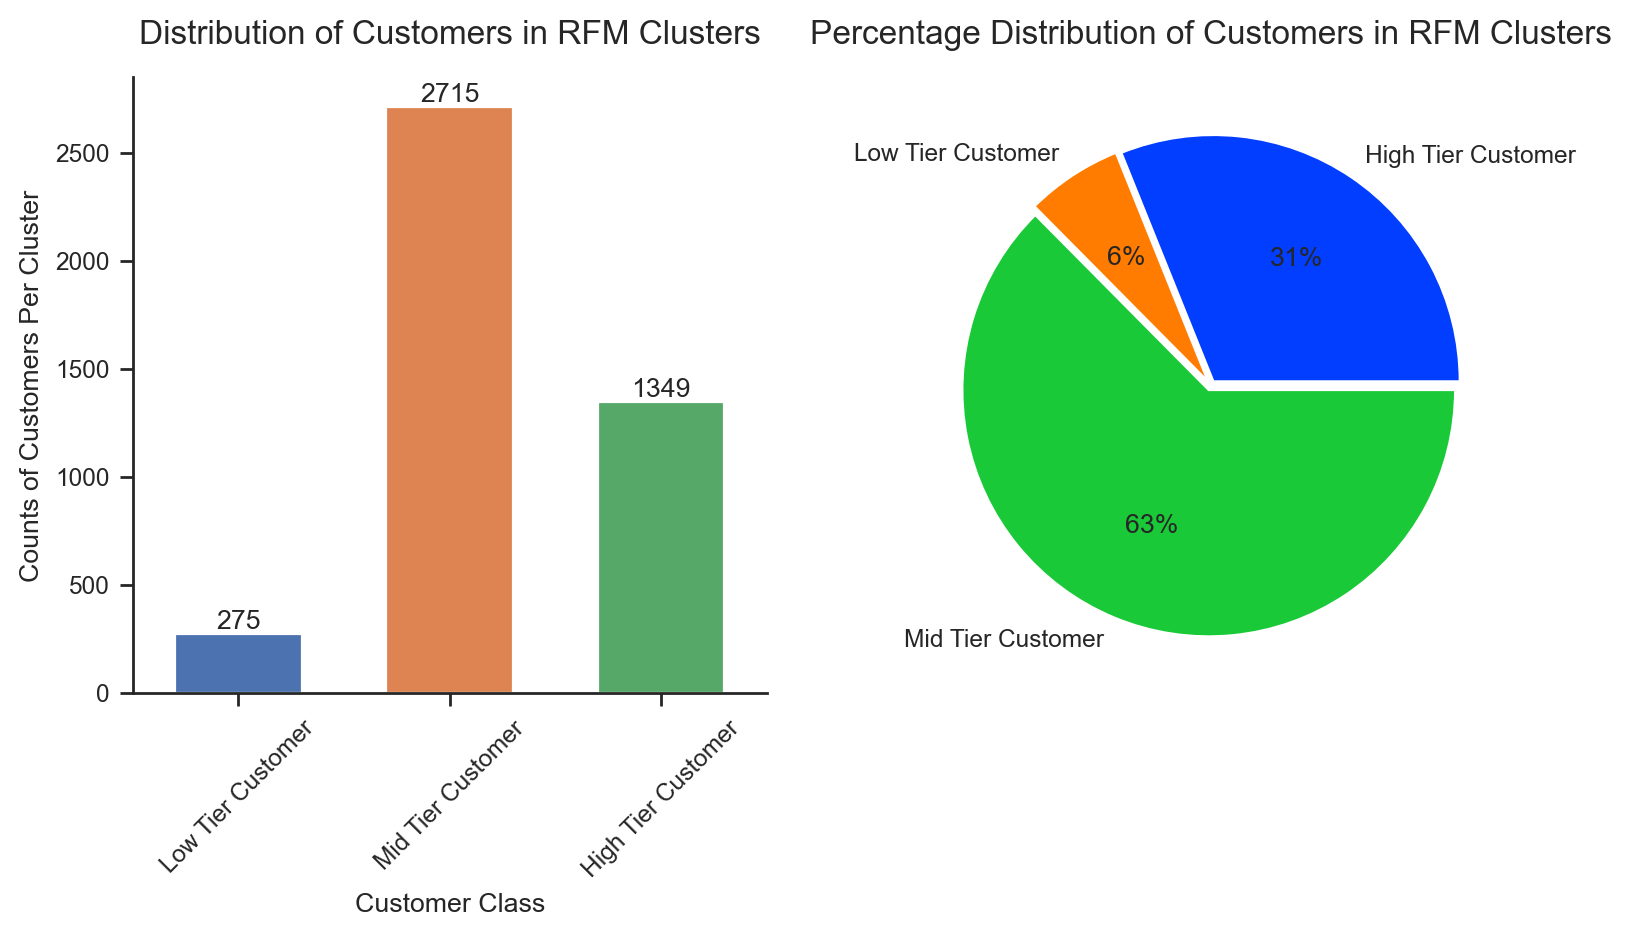

In [898]:
# plotting counts of each customer class
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
df_rfm = df_rfm.sort_values(by='RFM_Score', ascending=True)
ax1 = sns.countplot(data=df_rfm, x='Customer_Class', saturation=1.0, width=0.60)
ax1.bar_label(ax1.containers[0])  # display figures on top of bars
ax1.tick_params('x', labelrotation=45)
sns.despine(fig=None, ax=ax1, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax1.set_title('Distribution of Customers in RFM Clusters', fontsize=12)
ax1.set_xlabel('Customer Class')
ax1.set_ylabel('Counts of Customers Per Cluster')

# plotting pie chart of customer classes
ax2 = fig.add_subplot(122)
colors = sns.color_palette('bright')
df_pie = df_rfm.Customer_Class.value_counts().to_frame().sort_index()
ax2.pie(x=df_pie.Customer_Class, labels=df_pie.index, colors=colors, autopct='%.0f%%', explode=[0.02, 0.02, 0.02])
ax2.set_title('Percentage Distribution of Customers in RFM Clusters', fontsize=12)
plt.show()
fig.savefig('C:/Users/tomna/Desktop/Desktop/Notebooks/E-commerce/Distribution_of_Customers_in_RFM_Clusters.png', format='png', dpi=1200)

## Clustering Analysis

From the density distribution of the RFM scores above, we can see they are highly skewed (especially frequency and monetary scores). Before we perform clustering, we need to transform the scores in an attempt to make them normally distributed.

In [899]:
# handling nearly zero values because log transformation of these values would result in infinte values
# creating a function to manage zero values
def handle_zero_values(x):
    if x <= 0:
        return 1
    else:
        return x
    
# applying the function
df_rfm.Recency = df_rfm.Recency.apply(handle_zero_values)
df_rfm.Frequency = df_rfm.Frequency.apply(handle_zero_values)
df_rfm.Monetary = df_rfm.Monetary.apply(handle_zero_values)

In [900]:
# transforming the RFM score into log form
df_rfm_log = df_rfm[cols].apply(np.log, axis=0).round(2)
df_rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
13256,3.71,0.0,0.00
13638,3.74,0.0,4.81
14569,3.33,0.0,5.43
18015,3.43,0.0,4.79
13560,3.53,0.0,5.14


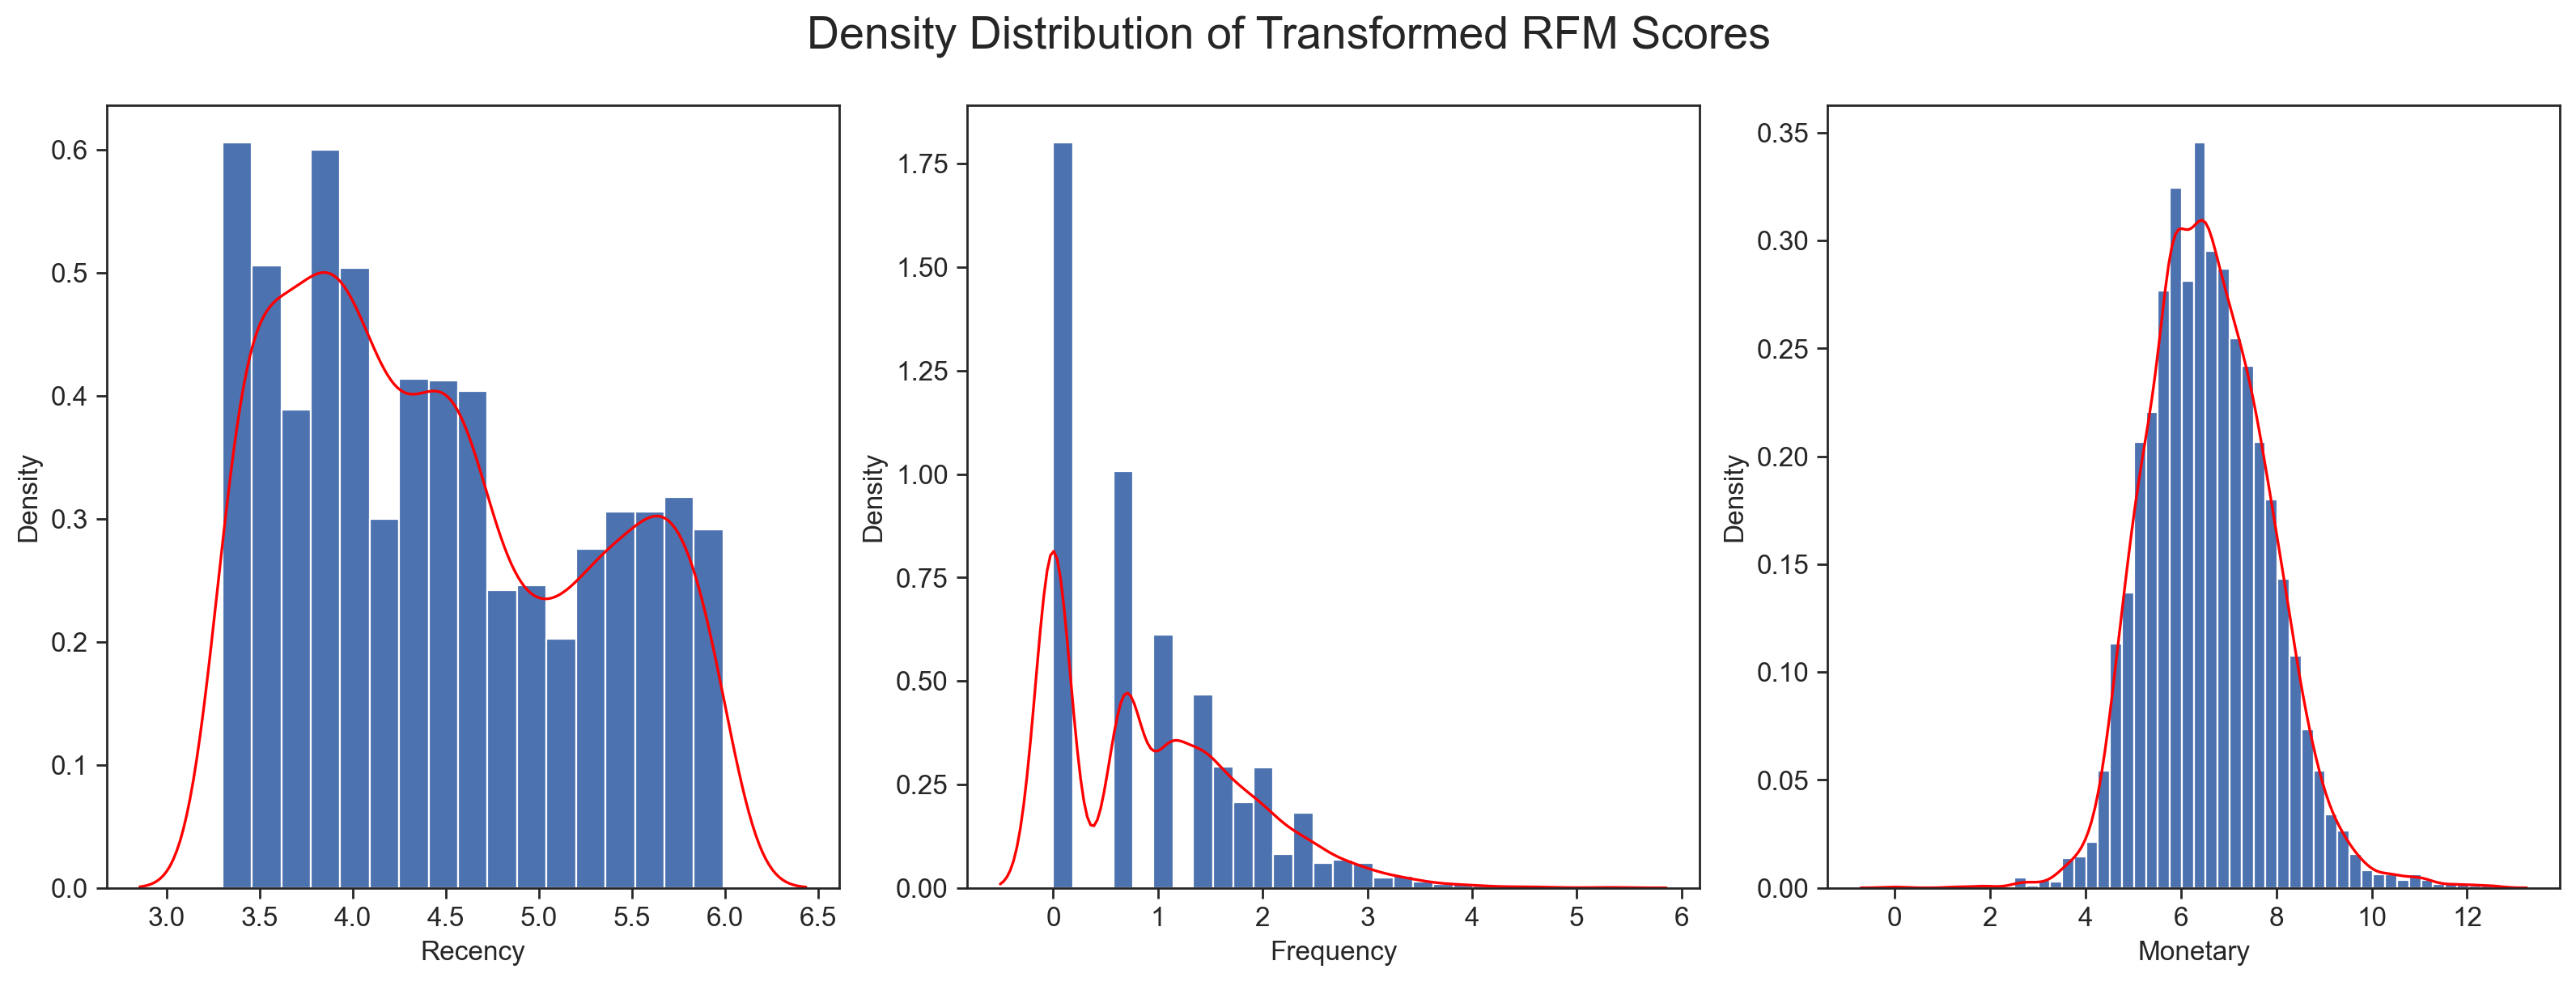

In [901]:
# plotting density distribution of the transformed RFM scores 
plt.figure(figsize = (16, 6))
subplot_num = 1
for col in cols:
    if subplot_num <= len(cols):
        plt.subplot(1, 3, subplot_num)
        # to draw a kde line with a different color, histogram and density have to be drawn as seprate plots
        ax = sns.distplot(df_rfm_log[col], kde=True, hist=True, hist_kws={'alpha':1})
        ax.lines[0].set_color('red')
    subplot_num += 1
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
plt.suptitle("Density Distribution of Transformed RFM Scores", fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

In [902]:
# dropping the index 'Customer_ID' as it is not needed for the analysis
df_rfm_log.reset_index(drop=True, inplace=True)
df_rfm_log.head()

,Recency,Frequency,Monetary
0,3.71,0.0,0.00
1,3.74,0.0,4.81
2,3.33,0.0,5.43
3,3.43,0.0,4.79
4,3.53,0.0,5.14


In [903]:
# checking if there missing values
df_rfm_log.isnull().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [904]:
# Standardizing the variables
#df_X = df_rfm_log
X = df_rfm_log.values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
df_X_scaled = pd.DataFrame(X_scaled, columns=cols)
df_X_scaled.head()

,Recency,Frequency,Monetary
0,-0.949887,-1.047872,-5.203235
1,-0.911855,-1.047872,-1.402112
2,-1.431627,-1.047872,-0.912154
3,-1.304853,-1.047872,-1.417917
4,-1.178080,-1.047872,-1.141328


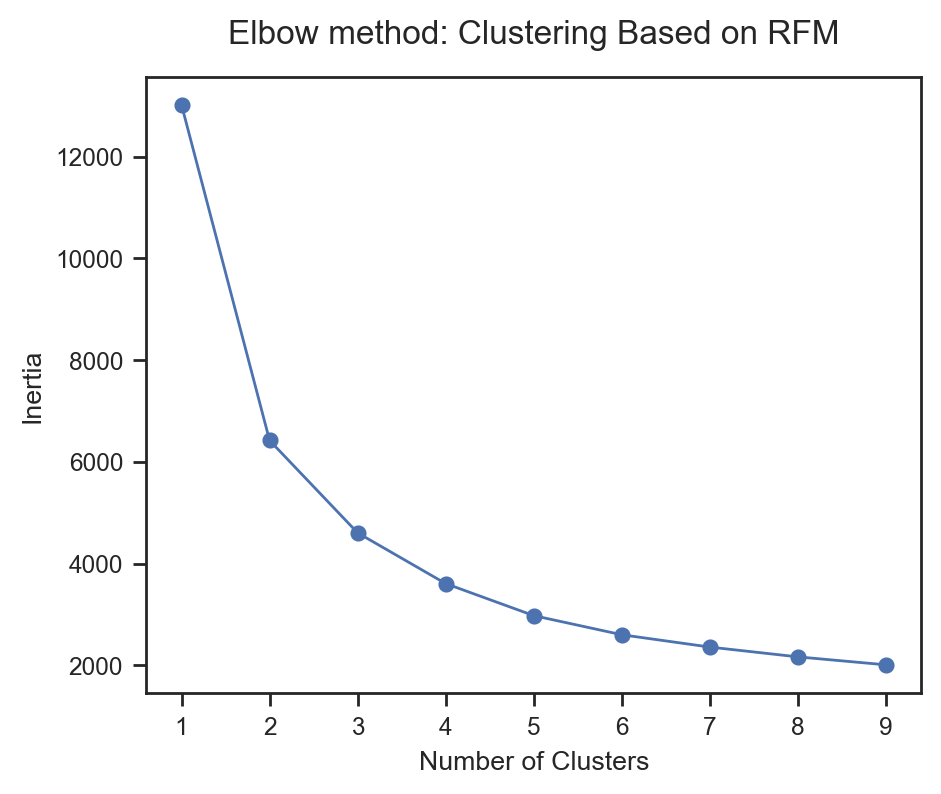

In [905]:
wcss = []
max_value = 10
for k in range(1, max_value):
    k_means = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, random_state=42)
    k_means.fit(X_scaled)
    wcss.append(k_means.inertia_)
# plotting the wcss values
plt.figure(figsize=(5,4))
plt.plot(range(1, 10), wcss, linewidth=1.0, marker='o')
plt.title('Elbow method: Clustering Based on RFM', fontsize=12)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 10))
plt.show()

In [906]:
# determining the best number of clusters automatically
from kneed import KneeLocator
kl = KneeLocator(range(1, max_value), wcss, curve="convex", direction="decreasing")
print('Elbow Point:', kl.elbow)

Elbow Point: 3


#### KMeans Clustering

In [907]:
# defining a list for holding results of each algorithm as dataframe
models_results_list = []

In [908]:
# building a kmeans model with 3 clusters
model_name = 'KMeans'
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_X_scaled)
kmeans_cluster_labels = kmeans.labels_
#kmeans_cluster_centers = kmeans.cluster_centers_
print('KMeans Predicted Labels:')
kmeans_cluster_labels

KMeans Predicted Labels:


array([0, 2, 2, ..., 1, 1, 1])

In [909]:
print('Unique Cluster Labels: ', np.unique(kmeans_cluster_labels))

Unique Cluster Labels:  [0 1 2]


In [910]:
# evaluating the model using silhouette_score. 
# this is a coefficient value that ranges from -1 to +1. A higher silhouette score is indicative of a better model.
kmeans_sil_score = silhouette_score(df_X_scaled, kmeans_cluster_labels, metric='euclidean')
print(round(kmeans_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score":kmeans_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.358


#### Hierarchical Clustering

In [911]:
# clustering using Hierarchical Clustering approach
model_name = 'Agglomerative Clustering'
agg_model = AgglomerativeClustering(n_clusters=3)
agg_model.fit(df_X_scaled)
agg_cluster_labels = agg_model.labels_

In [912]:
print('Unique Cluster Labels: ', np.unique(agg_cluster_labels))

Unique Cluster Labels:  [0 1 2]


In [913]:
# evaluating the model using silhouette_score. 
# this is a coefficient value that ranges from -1 to +1. A higher silhouette score is indicative of a better model.
agg_sil_score = silhouette_score(df_X_scaled, agg_cluster_labels, metric='euclidean')
print(round(agg_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": agg_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.333


#### Gaussian Mixture Model (GMM)

In [914]:
model_name = 'Gaussian Mixture'
gmm_model = GaussianMixture(n_components=3, random_state=0)
gmm_pred_labels = gmm_model.fit_predict(df_X_scaled)

In [915]:
print('Unique Cluster Labels: ', np.unique(gmm_pred_labels))

Unique Cluster Labels:  [0 1 2]


In [916]:
# evaluating the model using silhouette_score. 
gmm_sil_score = silhouette_score(df_X_scaled, gmm_pred_labels, metric='euclidean')
print(round(gmm_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": gmm_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.252


#### Spectral Clustering

In [917]:
model_name = 'Spectral Clustering'
spectral_model= SpectralClustering(n_clusters=5, random_state=0, n_neighbors=8, affinity='nearest_neighbors')
spectral_model.fit(df_X_scaled)
spectral_cluster_labels = spectral_model.labels_

In [918]:
print('Unique Cluster Labels: ', np.unique(spectral_cluster_labels))

Unique Cluster Labels:  [0 1 2 3 4]


In [919]:
# evaluating the model using silhouette_score. 
spectral_sil_score = silhouette_score(df_X_scaled, spectral_cluster_labels, metric='euclidean')
print(round(spectral_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": gmm_sil_score}, index=[model_name])
models_results_list.append(df_model_results)

0.209


#### DBSCAN Clustering

In [920]:
model_name = 'DBSCAN'
dbs_model = DBSCAN(eps=0.25, min_samples=9)
dbs_pred_clusters = dbs_model.fit_predict(df_X_scaled)

In [921]:
print('Unique Cluster Labels: ', np.unique(dbs_pred_clusters))

Unique Cluster Labels:  [-1  0  1  2  3  4]


In [922]:
# evaluating the model using silhouette_score. 
dbs_sil_score = silhouette_score(df_X_scaled, dbs_pred_clusters, metric='euclidean')
print(round(dbs_sil_score, 3))
df_model_results = pd.DataFrame({"silhouette_score": dbs_sil_score}, index=[model_name])

0.043


In [923]:
# combile the models' results in a dataframe for comparison
models_results_list.append(df_model_results)
df_results = pd.concat(models_results_list, axis=0).round(3)  # appending dataframes row-wise
# convert index to xolumn and rename the columns
df_results.reset_index(inplace=True)
df_results.rename(columns={'index':'Model Name', 'silhouette_score': 'Silhouette Score'}, inplace=True)
df_results

,Model Name,Silhouette Score
0,KMeans,0.358
1,Agglomerative Clustering,0.333
2,Gaussian Mixture,0.252
3,Spectral Clustering,0.252
4,DBSCAN,0.043


It can be seen that the KMeans has the highest Silhouette Score thus the best model for this problem. We therefore use the model for clustering analysis

In [924]:
df_rfm['Cluster'] = kmeans_cluster_labels
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Score,Customer_Class,Cluster
CustomerID,,,,,,,,,,
13256,41,1,1.00,1,1,1,111,3,Low Tier Customer,0
13638,42,1,122.64,1,1,1,111,3,Low Tier Customer,2
14569,28,1,227.39,1,1,1,111,3,Low Tier Customer,2
18015,31,1,120.03,1,1,1,111,3,Low Tier Customer,2
13560,34,1,171.42,1,1,1,111,3,Low Tier Customer,2


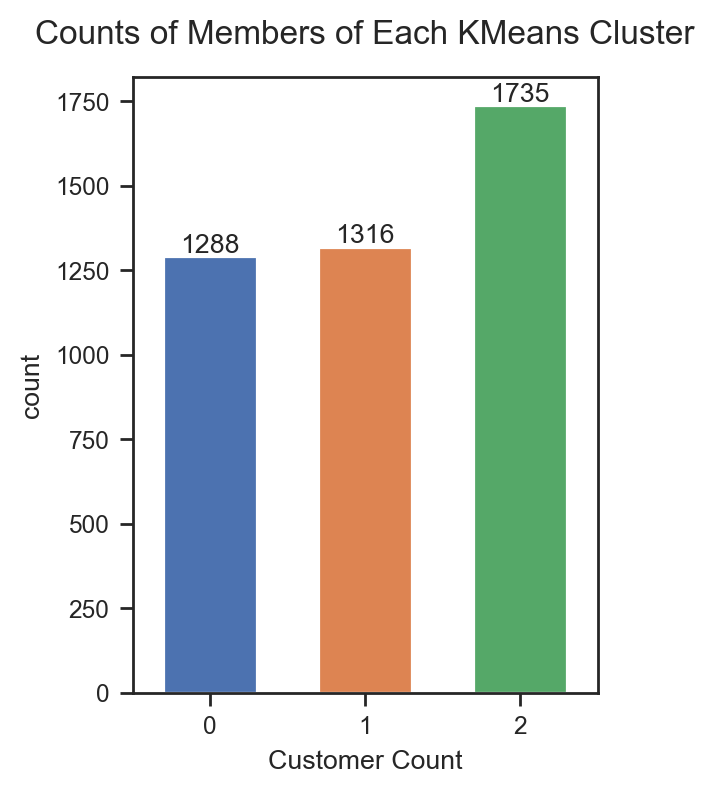

In [925]:
# plotting counts of Cluster columns
plt.figure(figsize=(3,4))
ax = sns.countplot(data=df_rfm, x='Cluster', saturation=1.0, width=0.6)
ax.bar_label(ax.containers[0])  # display figures on top of bars
plt.title('Counts of Members of Each KMeans Cluster', fontsize=12)
plt.xlabel('Cluster')
plt.xlabel('Customer Count')
plt.show()

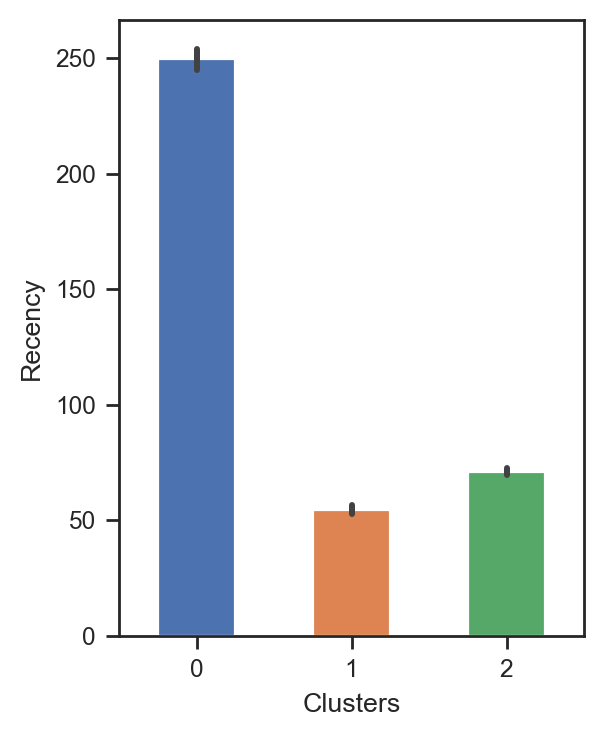

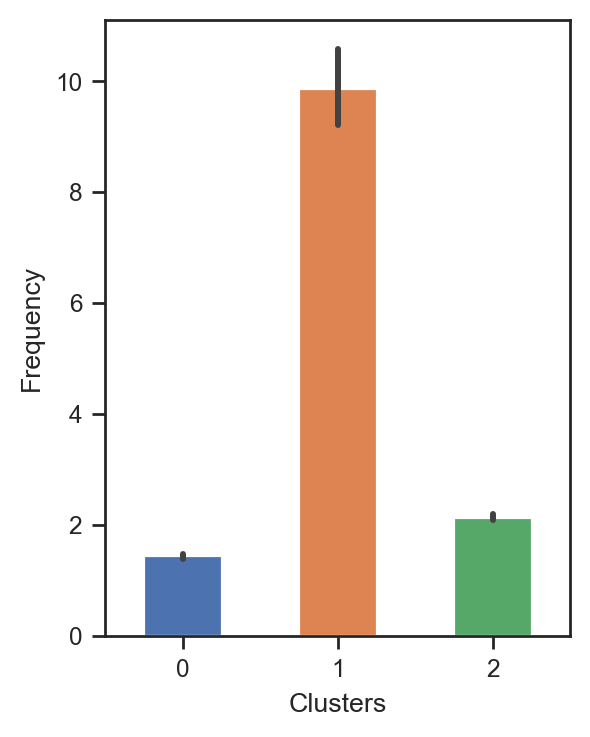

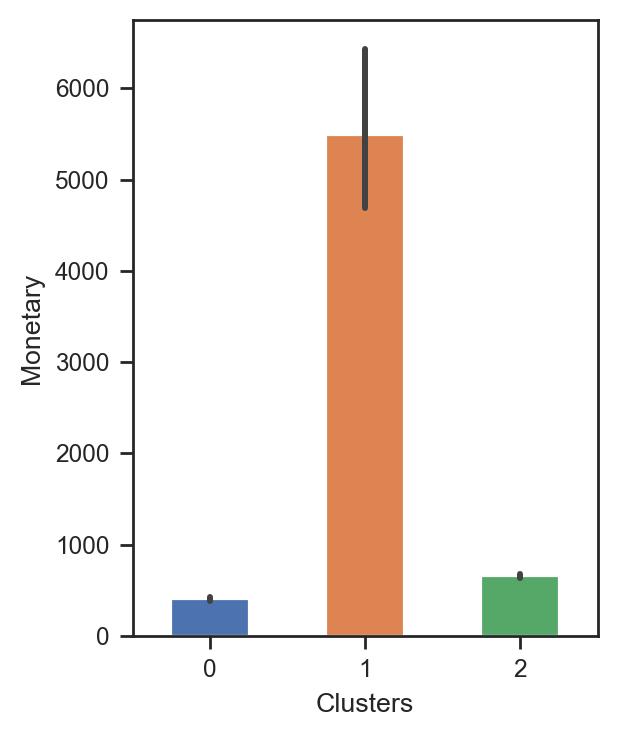

In [926]:
# visualizing the clusters
for col in cols:
    plt.figure(figsize=(3,4))
    sns.barplot(x='Cluster', y=str(col), data=df_rfm, saturation=1.0, width=0.50)
    plt.xlabel('Clusters')
    plt.show()

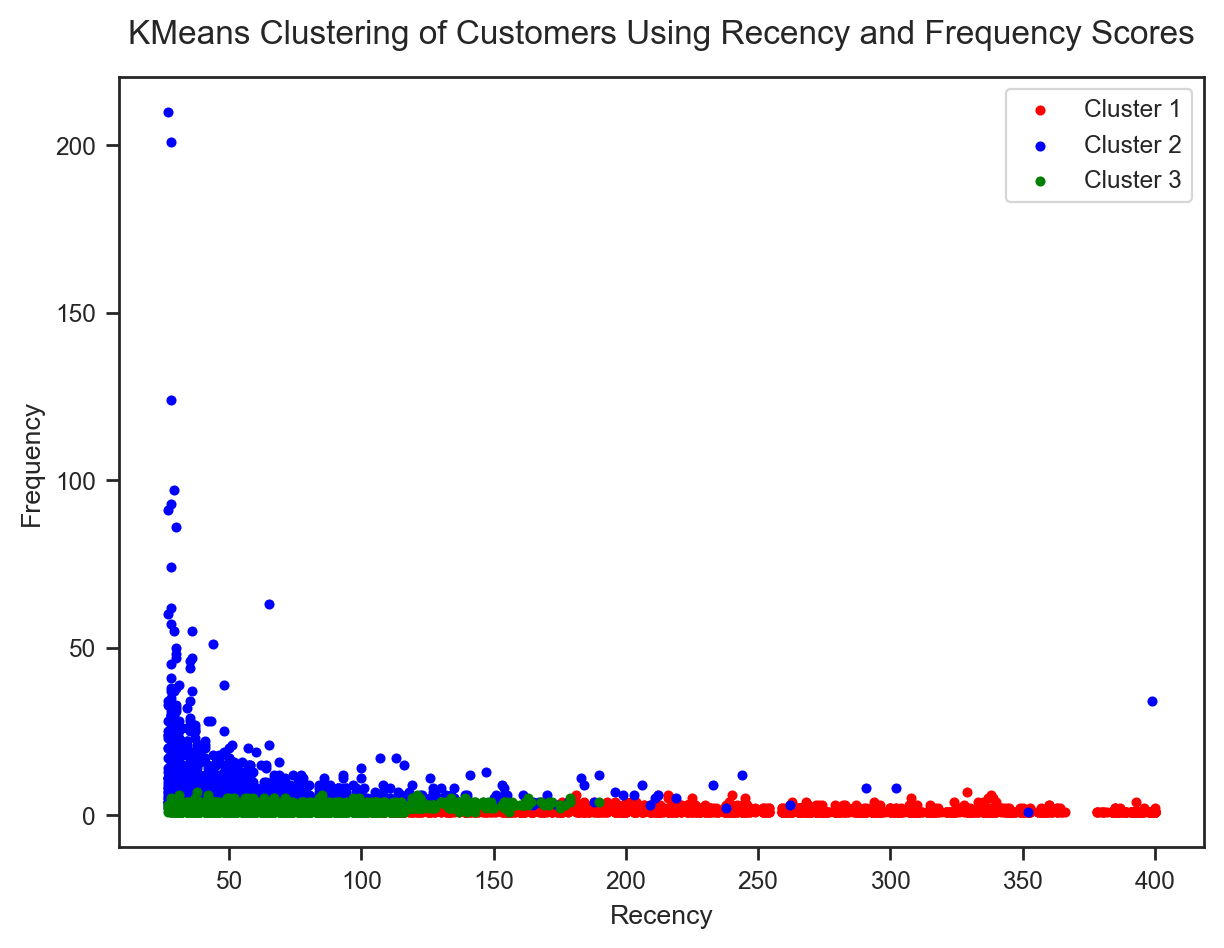

In [927]:
# Visualizing the data in two dimensions (Regency Vs Frequency)
#%matplotlib notebook
label = df_rfm['Cluster']
plt.figure(figsize=(7,5))
plt.scatter(df_rfm[label==0]['Recency'], df_rfm[label==0]['Frequency'], label='Cluster 1', c='red', s=8)
plt.scatter(df_rfm[label==1]['Recency'], df_rfm[label==1]['Frequency'], label='Cluster 2', c='blue', s=8)
plt.scatter(df_rfm[label==2]['Recency'], df_rfm[label==2]['Frequency'], label='Cluster 3', c='green', s=8)
plt.legend()
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('KMeans Clustering of Customers Using Recency and Frequency Scores', fontsize=12)
plt.show()

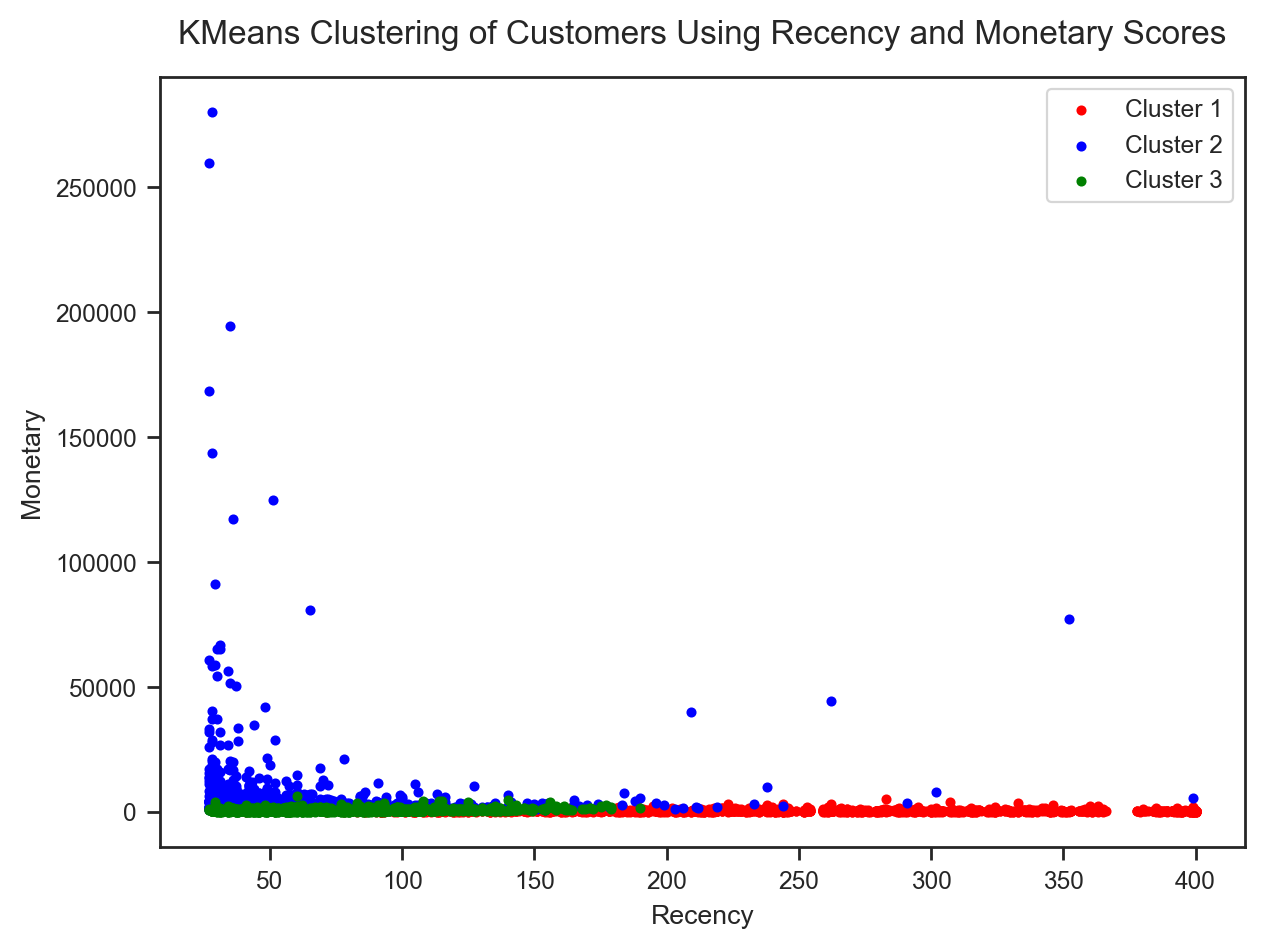

In [928]:
# Visualizing the data in two dimensions (Regency Vs Monetary)
#%matplotlib notebook
plt.figure(figsize=(7,5))
plt.scatter(df_rfm[label==0]['Recency'], df_rfm[label==0]['Monetary'], label='Cluster 1', c='red', s=8)
plt.scatter(df_rfm[label==1]['Recency'], df_rfm[label==1]['Monetary'], label='Cluster 2', c='blue', s=8)
plt.scatter(df_rfm[label==2]['Recency'], df_rfm[label==2]['Monetary'], label='Cluster 3', c='green', s=8)
plt.legend()
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('KMeans Clustering of Customers Using Recency and Monetary Scores', fontsize=12)
plt.show()

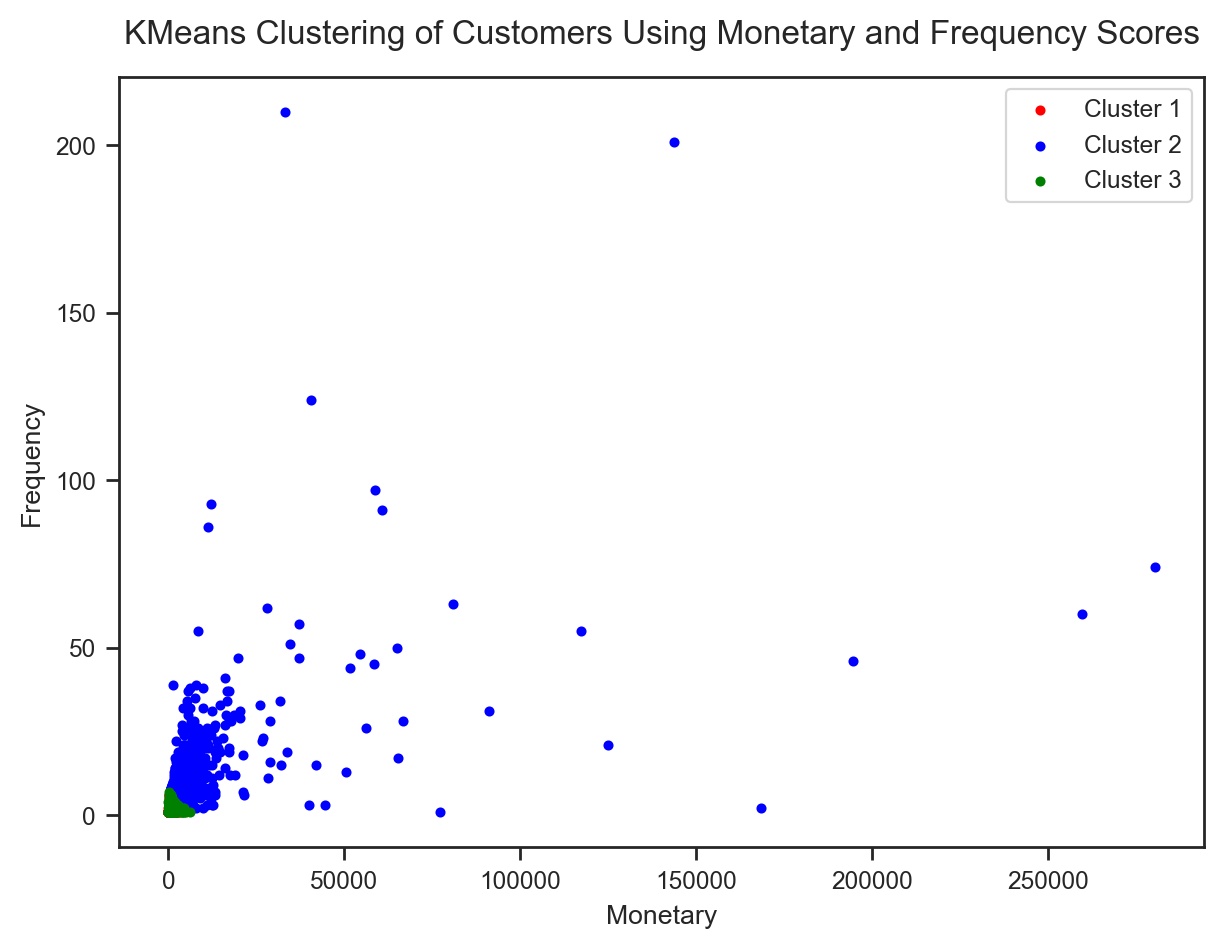

In [929]:
# Visualizing the data in two dimensions (Monetary Vs Frequency)
#%matplotlib notebook
plt.figure(figsize=(7,5))
plt.scatter(df_rfm[label==0]['Monetary'], df_rfm[label==0]['Frequency'], label='Cluster 1', c='red', s=8)
plt.scatter(df_rfm[label==1]['Monetary'], df_rfm[label==1]['Frequency'], label='Cluster 2', c='blue', s=8)
plt.scatter(df_rfm[label==2]['Monetary'], df_rfm[label==2]['Frequency'], label='Cluster 3', c='green', s=8)
plt.legend()
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('KMeans Clustering of Customers Using Monetary and Frequency Scores', fontsize=12)
plt.show()

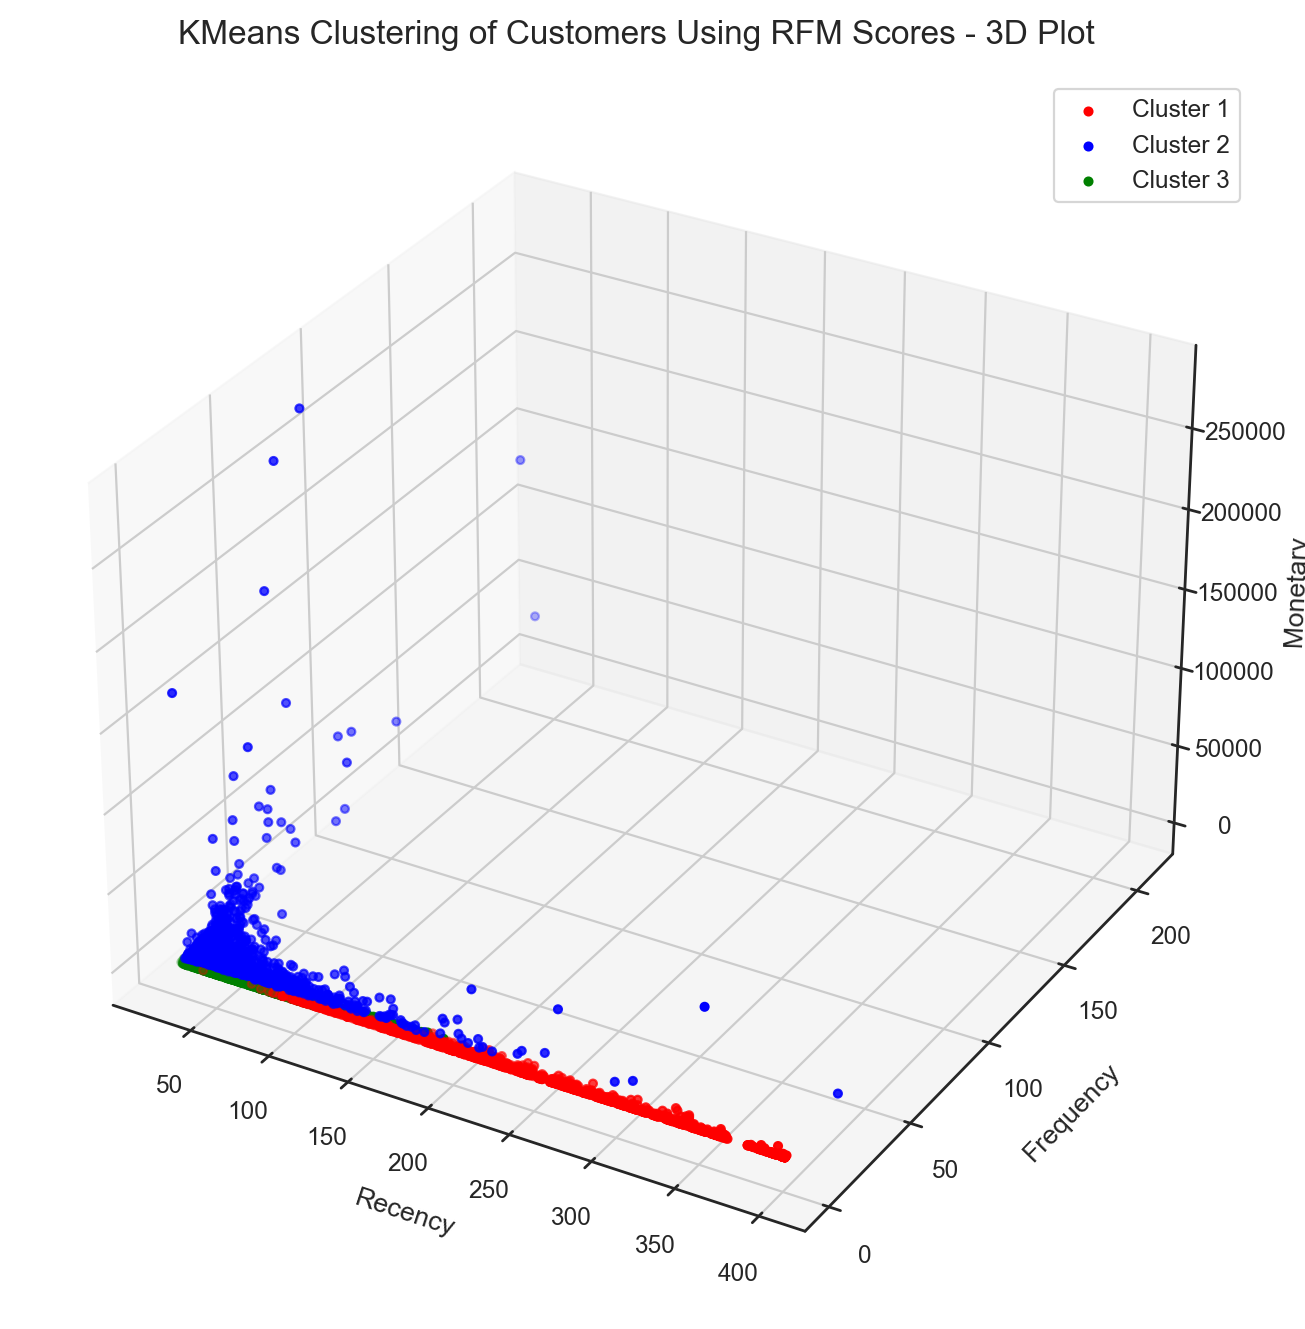

In [930]:
# Visualizing the data in 3D
#%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(df_rfm[label==0]['Recency'], df_rfm[label==0]['Frequency'], df_rfm[label==0]['Monetary'], label='Cluster 1',c='red', s=8)
ax.scatter(df_rfm[label==1]['Recency'], df_rfm[label==1]['Frequency'], df_rfm[label==1]['Monetary'], label='Cluster 2',c='blue', s=8)
ax.scatter(df_rfm[label==2]['Recency'], df_rfm[label==2]['Frequency'], df_rfm[label==2]['Monetary'], label='Cluster 3',c='green', s=8)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('KMeans Clustering of Customers Using RFM Scores - 3D Plot', fontsize=12)
plt.legend()
plt.show()
fig.savefig('C:/Users/tomna/Desktop/Desktop/Notebooks/E-commerce/KMeans_Clustering_of_RFM_Scores.png', format='png', dpi=1200)

Observations from the clustering analysis:

1) Customers belonging to cluster 1 with low recency appears to buy more frequent. For those of clusters 2 and 3, recency and frequency are not correlated.
2) Customers belonging to cluster 1 with low recency appears to spend more. For those of clusters 2 and 3, recency and monetary values are not correlated.
3) For Customers belonging to cluster 1, the amount of money they spend appears to be linearly correlated with their frequency of purchasing. This is not the case for those belonging to clusters 2 and 3.
4) For customers of Clusters 2 and 3, recency has no effect on their purchasing frequency and the amount spend.
5) A specific marketing strategy to attract cluster 1 customers to buy more often should be put in place to increase revenues. For cluster 2 and 3 customer, a strategy to attract them to buy more frequently and spend more should be adopted.